In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 129.50it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.90it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.27it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.49it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 200
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch    9, Loss:  26.9536:   5%|██▋                                                  | 10/200 [00:15<03:20,  1.06s/it]

Epoch  10, Train Regret:  26.5598%, Val Regret:  27.9583%


Epoch   19, Loss:  18.8505:  10%|█████▎                                               | 20/200 [00:27<03:07,  1.04s/it]

Epoch  20, Train Regret:  22.3607%, Val Regret:  24.4209%


Epoch   29, Loss:  12.4331:  15%|███████▉                                             | 30/200 [00:39<02:58,  1.05s/it]

Epoch  30, Train Regret:  22.1711%, Val Regret:  23.2998%


Epoch   39, Loss:   7.5962:  20%|██████████▌                                          | 40/200 [00:51<02:48,  1.05s/it]

Epoch  40, Train Regret:  20.5114%, Val Regret:  20.8483%


Epoch   49, Loss:  11.2209:  25%|█████████████▎                                       | 50/200 [01:03<02:35,  1.04s/it]

Epoch  50, Train Regret:  18.2436%, Val Regret:  18.6697%


Epoch   59, Loss:   6.6272:  30%|███████████████▉                                     | 60/200 [01:15<02:26,  1.04s/it]

Epoch  60, Train Regret:  17.1757%, Val Regret:  18.0560%


Epoch   69, Loss:   5.5917:  35%|██████████████████▌                                  | 70/200 [01:27<02:14,  1.04s/it]

Epoch  70, Train Regret:  16.4065%, Val Regret:  17.8589%


Epoch   79, Loss:   8.0900:  40%|█████████████████████▏                               | 80/200 [01:40<02:04,  1.04s/it]

Epoch  80, Train Regret:  16.5689%, Val Regret:  17.1760%


Epoch   89, Loss:   4.9189:  45%|███████████████████████▊                             | 90/200 [01:52<01:54,  1.04s/it]

Epoch  90, Train Regret:  16.7718%, Val Regret:  17.3690%


Epoch   99, Loss:   9.0128:  50%|██████████████████████████                          | 100/200 [02:04<01:44,  1.04s/it]

Epoch 100, Train Regret:  16.2603%, Val Regret:  16.4020%


Epoch  109, Loss:   6.0729:  55%|████████████████████████████▌                       | 110/200 [02:16<01:33,  1.04s/it]

Epoch 110, Train Regret:  15.6664%, Val Regret:  17.0725%


Epoch  119, Loss:  13.3693:  60%|███████████████████████████████▏                    | 120/200 [02:28<01:23,  1.04s/it]

Epoch 120, Train Regret:  15.5406%, Val Regret:  16.2942%


Epoch  129, Loss:   5.4347:  65%|█████████████████████████████████▊                  | 130/200 [02:40<01:13,  1.04s/it]

Epoch 130, Train Regret:  15.7107%, Val Regret:  16.2797%


Epoch  139, Loss:   7.0661:  70%|████████████████████████████████████▍               | 140/200 [02:53<01:02,  1.05s/it]

Epoch 140, Train Regret:  14.9283%, Val Regret:  15.9984%


Epoch  149, Loss:  11.8526:  75%|███████████████████████████████████████             | 150/200 [03:05<00:52,  1.04s/it]

Epoch 150, Train Regret:  15.3930%, Val Regret:  15.5564%


Epoch  159, Loss:  17.3737:  80%|█████████████████████████████████████████▌          | 160/200 [03:17<00:41,  1.04s/it]

Epoch 160, Train Regret:  15.6317%, Val Regret:  16.1771%


Epoch  169, Loss:   7.2706:  85%|████████████████████████████████████████████▏       | 170/200 [03:29<00:31,  1.04s/it]

Epoch 170, Train Regret:  15.8812%, Val Regret:  16.6635%


Epoch  179, Loss:   5.2855:  90%|██████████████████████████████████████████████▊     | 180/200 [03:42<00:24,  1.23s/it]


Epoch 180, Train Regret:  14.4521%, Val Regret:  16.5971%

Early Stop!

Evaluation:
Test Regret: 16.9990%
Training Elapsed Time: 3.10 Sec


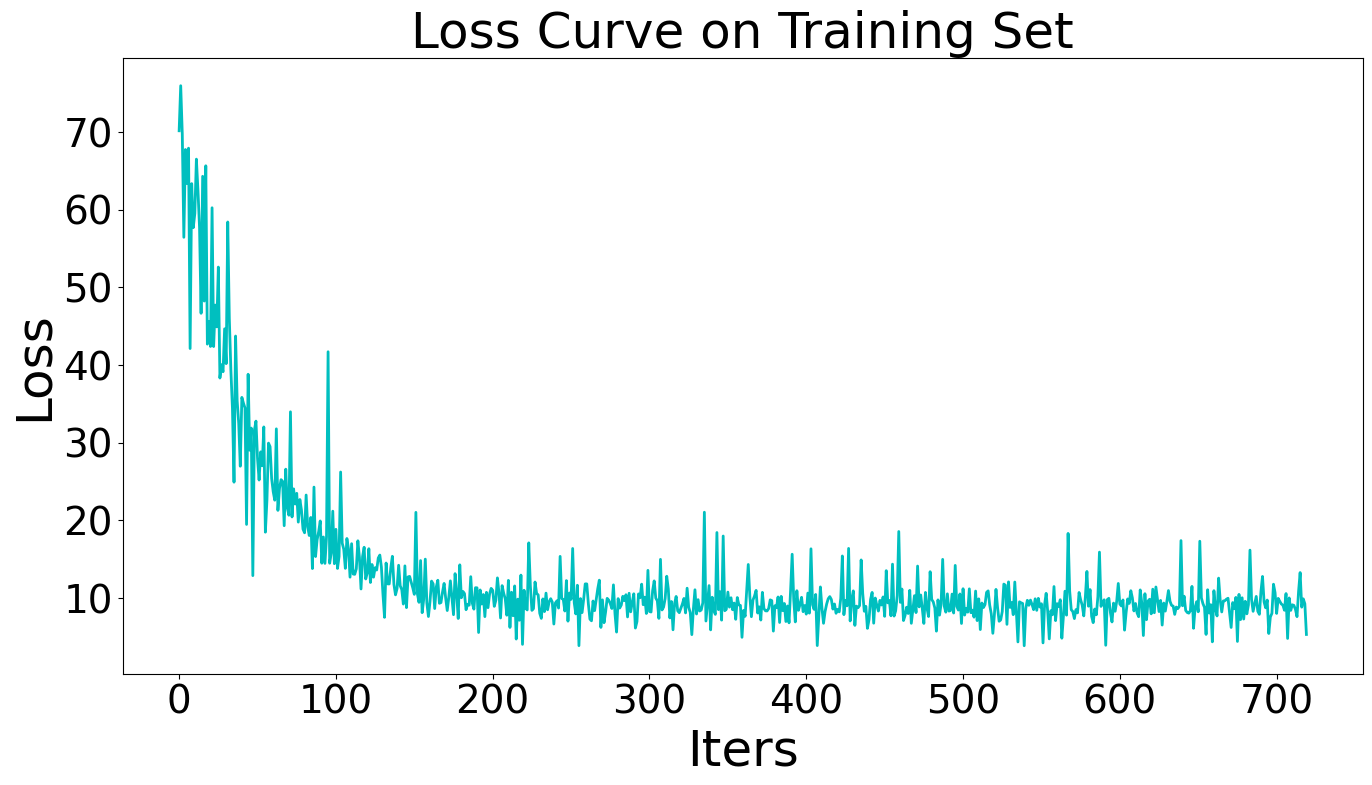

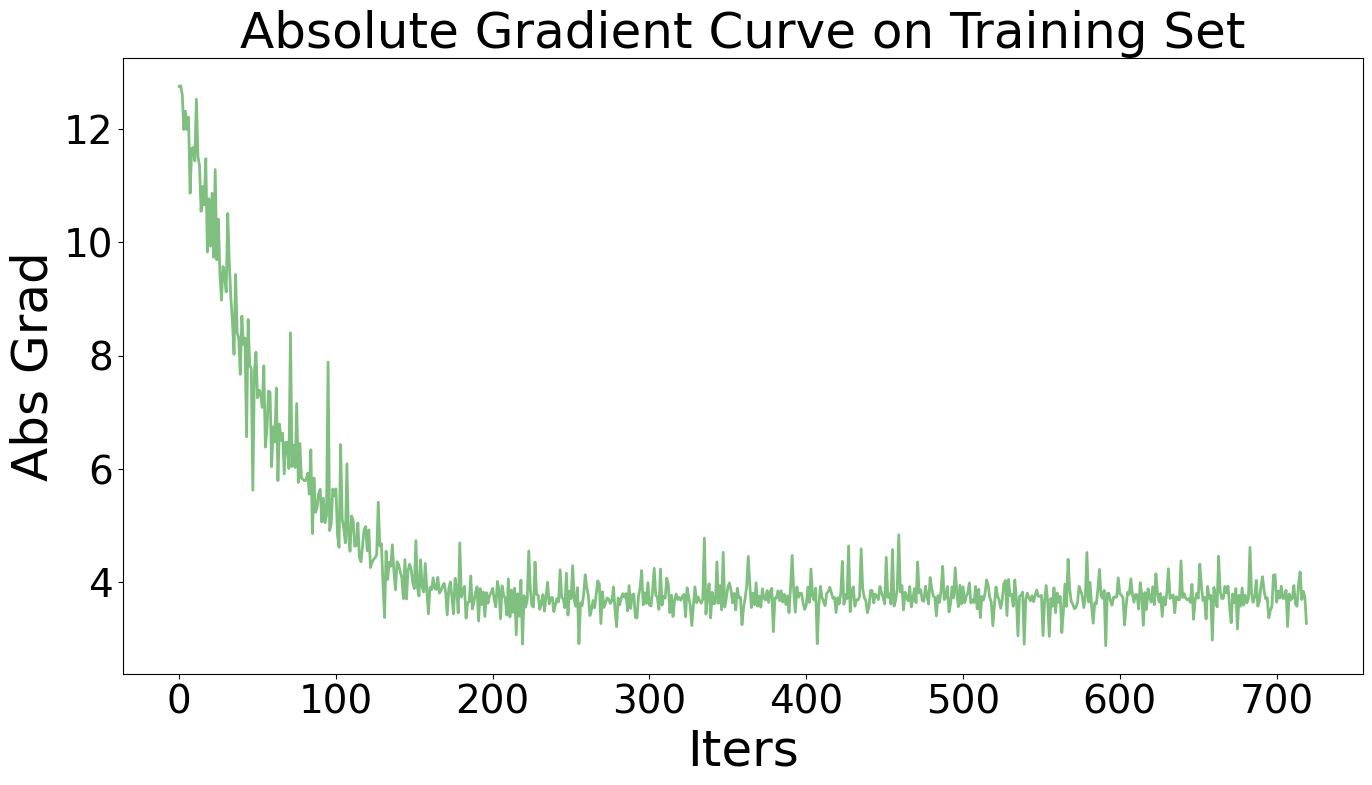

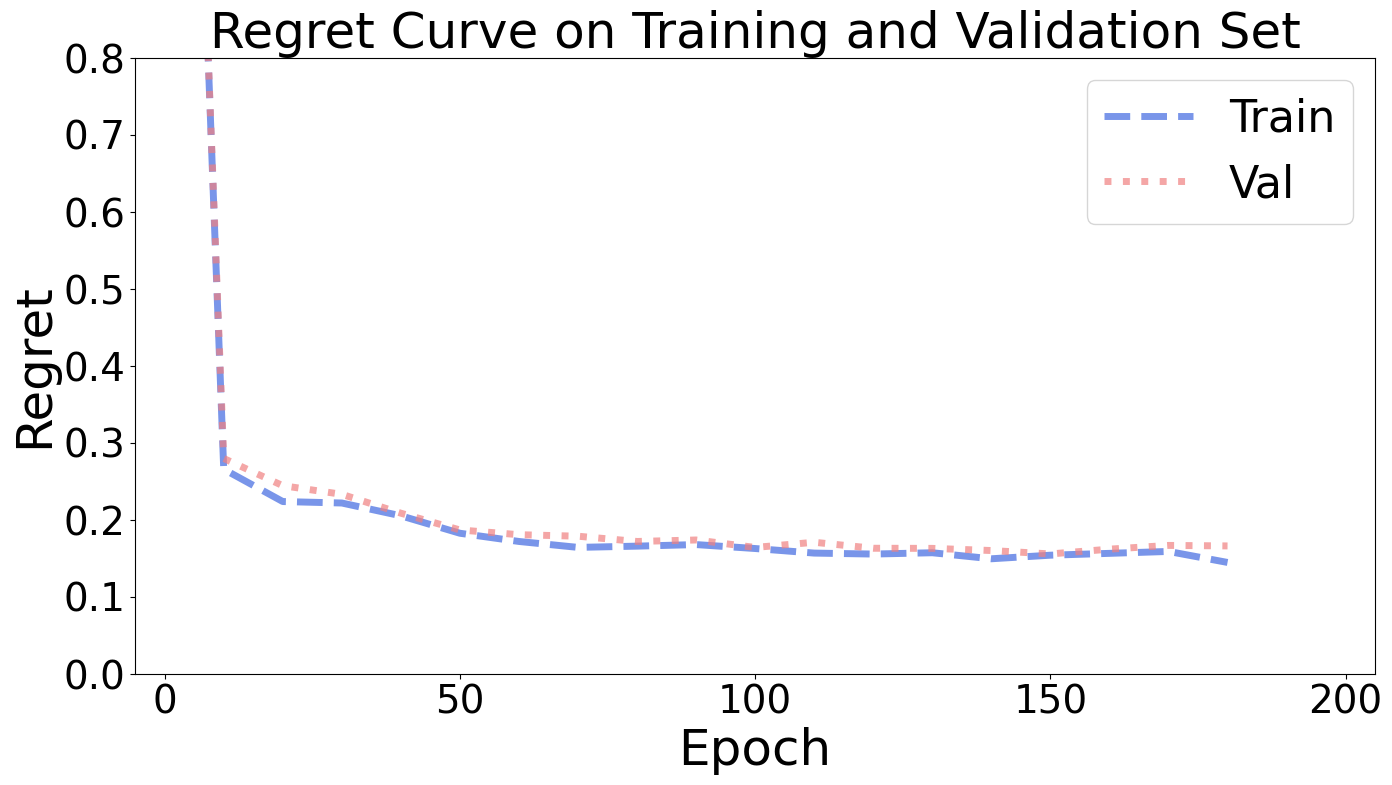

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 03 09:00:29 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 199.3609%, Val Regret: 185.2989%


Epoch    9, Loss:  -0.9994:   5%|██▋                                                  | 10/200 [00:35<07:37,  2.41s/it]

Epoch  10, Train Regret:  17.7019%, Val Regret:  32.0986%


Epoch   19, Loss:  -1.0000:  10%|█████▎                                               | 20/200 [00:59<06:28,  2.16s/it]

Epoch  20, Train Regret:  11.9808%, Val Regret:  26.8383%


Epoch   29, Loss:  -1.0000:  15%|███████▉                                             | 30/200 [01:22<06:03,  2.14s/it]

Epoch  30, Train Regret:   7.9090%, Val Regret:  27.1212%


Epoch   39, Loss:  -1.0000:  20%|██████████▌                                          | 40/200 [01:45<05:46,  2.16s/it]

Epoch  40, Train Regret:   6.2769%, Val Regret:  27.2949%


Epoch   49, Loss:  -1.0000:  25%|█████████████▎                                       | 50/200 [02:09<05:28,  2.19s/it]

Epoch  50, Train Regret:   5.3651%, Val Regret:  26.7464%


Epoch   59, Loss:  -1.0000:  30%|███████████████▉                                     | 60/200 [02:33<05:03,  2.17s/it]

Epoch  60, Train Regret:   4.1467%, Val Regret:  26.3060%


Epoch   69, Loss:  -1.0000:  35%|██████████████████▌                                  | 70/200 [02:55<04:28,  2.06s/it]

Epoch  70, Train Regret:   3.4109%, Val Regret:  26.4135%


Epoch   79, Loss:  -1.0000:  40%|█████████████████████▏                               | 80/200 [03:20<04:30,  2.25s/it]

Epoch  80, Train Regret:   1.7169%, Val Regret:  26.4713%


Epoch   89, Loss:  -1.0000:  45%|███████████████████████▊                             | 90/200 [03:46<04:36,  2.51s/it]


Epoch  90, Train Regret:   0.7813%, Val Regret:  26.4713%

Early Stop!

Evaluation:
Test Regret: 27.4780%
Training Elapsed Time: 115.21 Sec


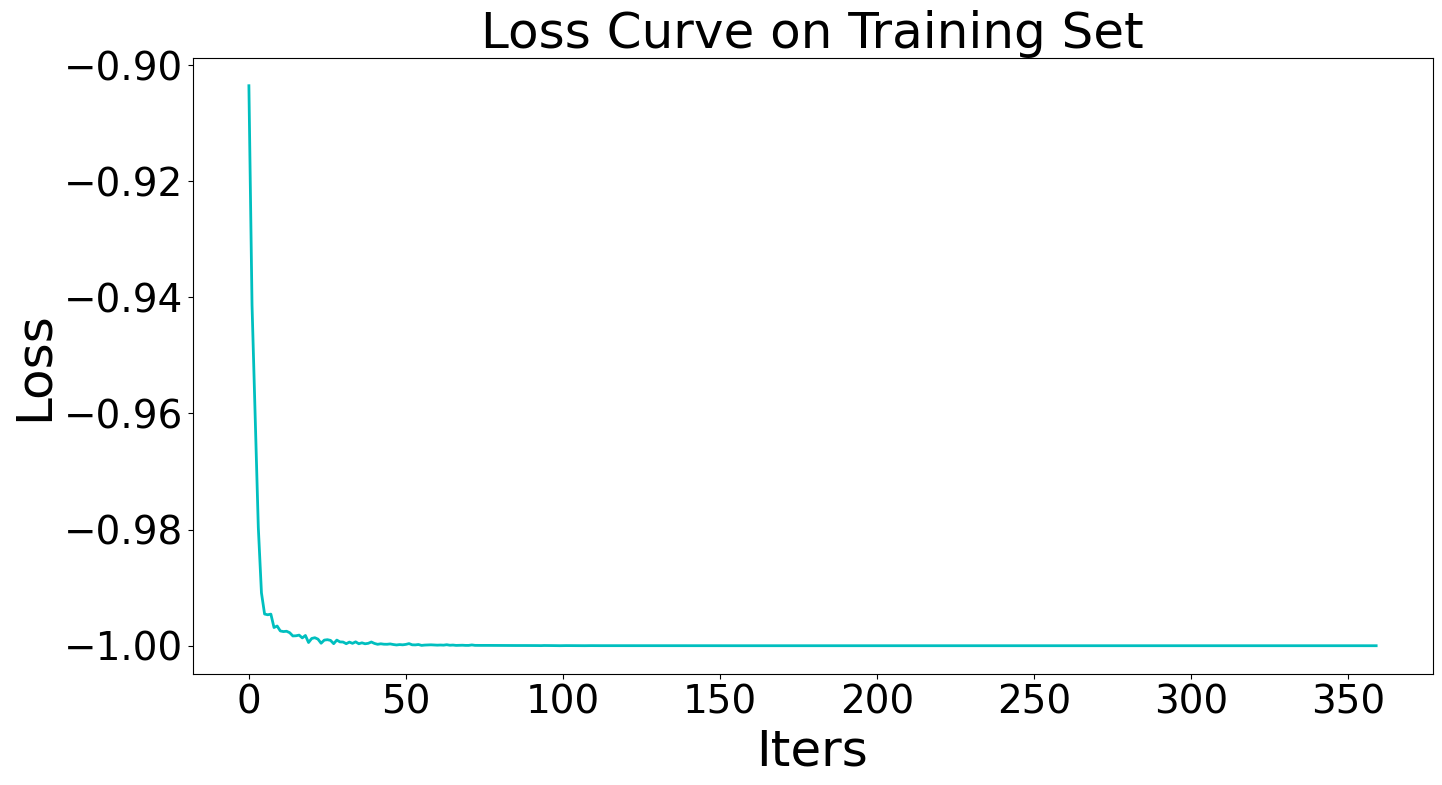

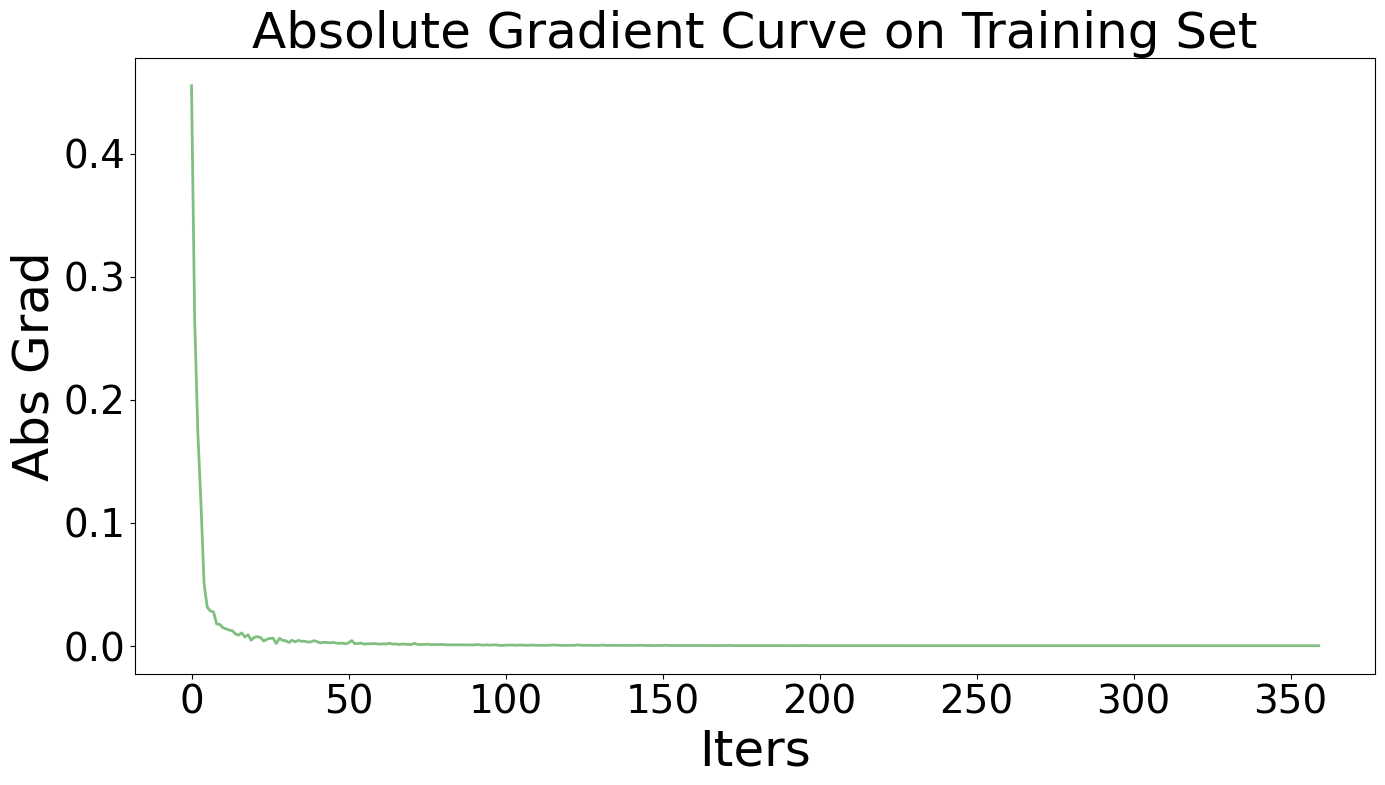

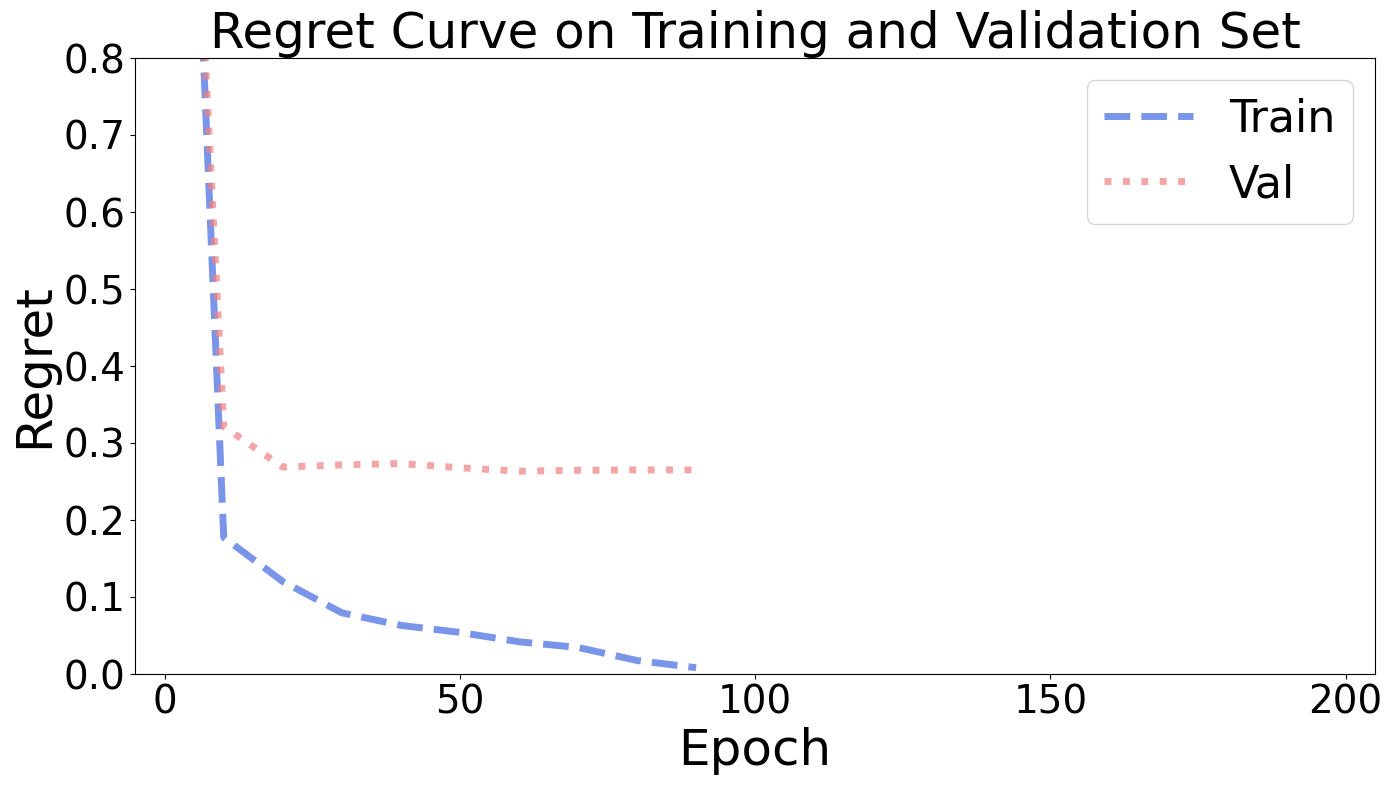

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [22]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 205.8223%, Val Regret: 193.8594%


Epoch    9, Loss:  -0.9993:   5%|██▋                                                  | 10/200 [00:26<07:05,  2.24s/it]

Epoch  10, Train Regret:  12.4363%, Val Regret:  27.9609%


Epoch   19, Loss:  -0.9998:  10%|█████▎                                               | 20/200 [00:50<06:43,  2.24s/it]

Epoch  20, Train Regret:   8.2183%, Val Regret:  20.1954%


Epoch   29, Loss:  -0.9999:  15%|███████▉                                             | 30/200 [01:14<05:57,  2.10s/it]

Epoch  30, Train Regret:   6.1303%, Val Regret:  19.2993%


Epoch   39, Loss:  -0.9998:  20%|██████████▌                                          | 40/200 [01:37<05:46,  2.17s/it]

Epoch  40, Train Regret:   7.3462%, Val Regret:  18.4702%


Epoch   49, Loss:  -0.9999:  25%|█████████████▎                                       | 50/200 [02:01<05:30,  2.20s/it]

Epoch  50, Train Regret:   6.3220%, Val Regret:  18.2341%


Epoch   59, Loss:  -0.9999:  30%|███████████████▉                                     | 60/200 [02:25<05:10,  2.22s/it]

Epoch  60, Train Regret:   7.9093%, Val Regret:  18.5653%


Epoch   69, Loss:  -0.9999:  35%|██████████████████▌                                  | 70/200 [02:50<04:47,  2.21s/it]

Epoch  70, Train Regret:   6.8134%, Val Regret:  17.4715%


Epoch   79, Loss:  -1.0000:  40%|█████████████████████▏                               | 80/200 [03:14<04:25,  2.21s/it]

Epoch  80, Train Regret:   6.7064%, Val Regret:  17.2117%


Epoch   89, Loss:  -0.9999:  45%|███████████████████████▊                             | 90/200 [03:38<04:02,  2.21s/it]

Epoch  90, Train Regret:   6.9475%, Val Regret:  17.2021%


Epoch   99, Loss:  -0.9999:  50%|██████████████████████████                          | 100/200 [04:02<03:39,  2.20s/it]

Epoch 100, Train Regret:   6.3251%, Val Regret:  17.0568%


Epoch  109, Loss:  -0.9999:  55%|████████████████████████████▌                       | 110/200 [04:27<03:18,  2.21s/it]

Epoch 110, Train Regret:   6.2111%, Val Regret:  17.2584%


Epoch  119, Loss:  -0.9999:  60%|███████████████████████████████▏                    | 120/200 [04:52<03:07,  2.34s/it]

Epoch 120, Train Regret:   6.5753%, Val Regret:  16.5807%


Epoch  129, Loss:  -0.9999:  65%|█████████████████████████████████▊                  | 130/200 [05:17<02:48,  2.41s/it]

Epoch 130, Train Regret:   6.8541%, Val Regret:  16.0522%


Epoch  139, Loss:  -1.0000:  70%|████████████████████████████████████▍               | 140/200 [05:44<02:26,  2.44s/it]

Epoch 140, Train Regret:   7.6548%, Val Regret:  16.9566%


Epoch  149, Loss:  -1.0000:  75%|███████████████████████████████████████             | 150/200 [06:09<02:02,  2.44s/it]

Epoch 150, Train Regret:   7.6631%, Val Regret:  16.5430%


Epoch  159, Loss:  -0.9999:  80%|█████████████████████████████████████████▌          | 160/200 [06:35<01:38,  2.47s/it]


Epoch 160, Train Regret:   7.2846%, Val Regret:  16.1582%

Early Stop!

Evaluation:
Test Regret: 16.5529%
Training Elapsed Time: 198.97 Sec


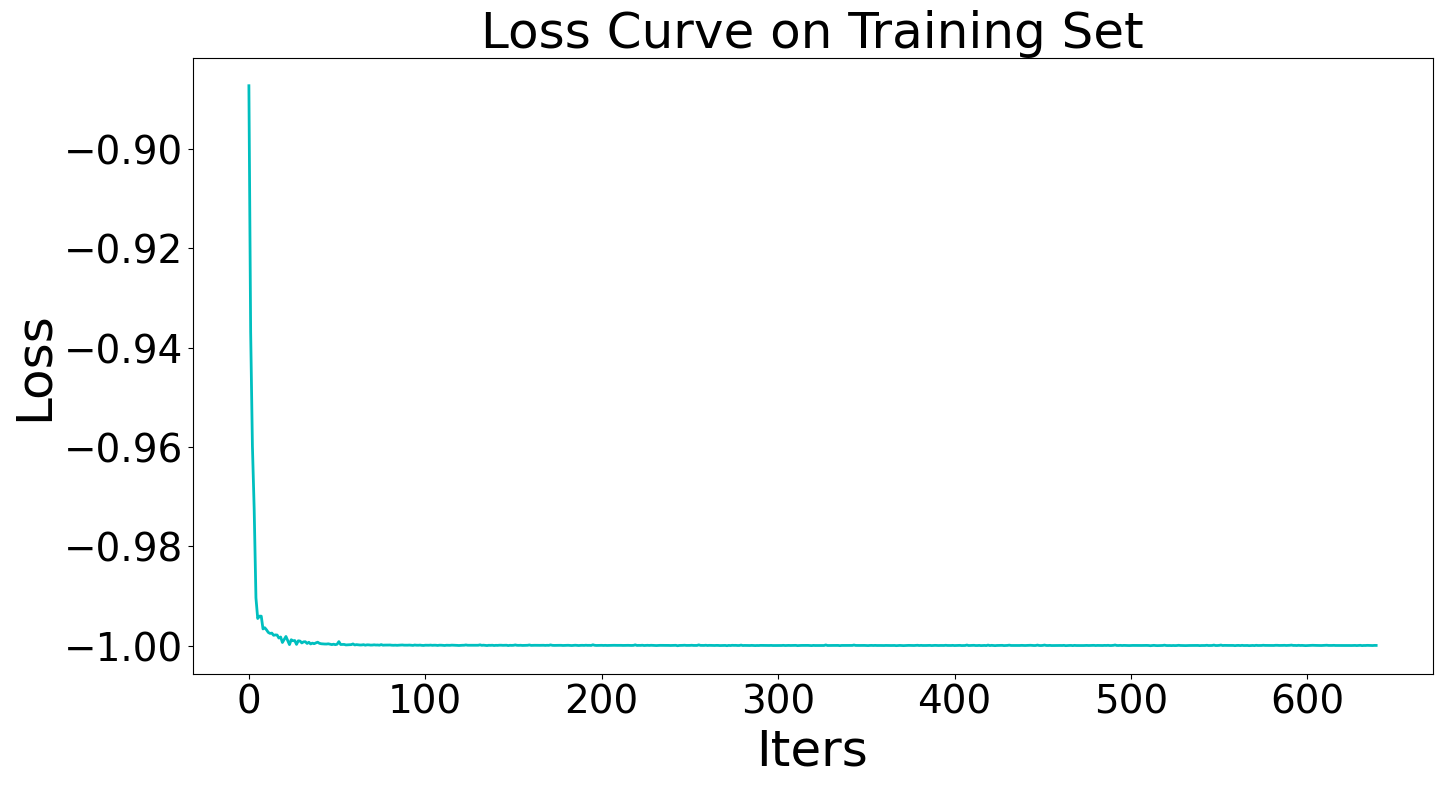

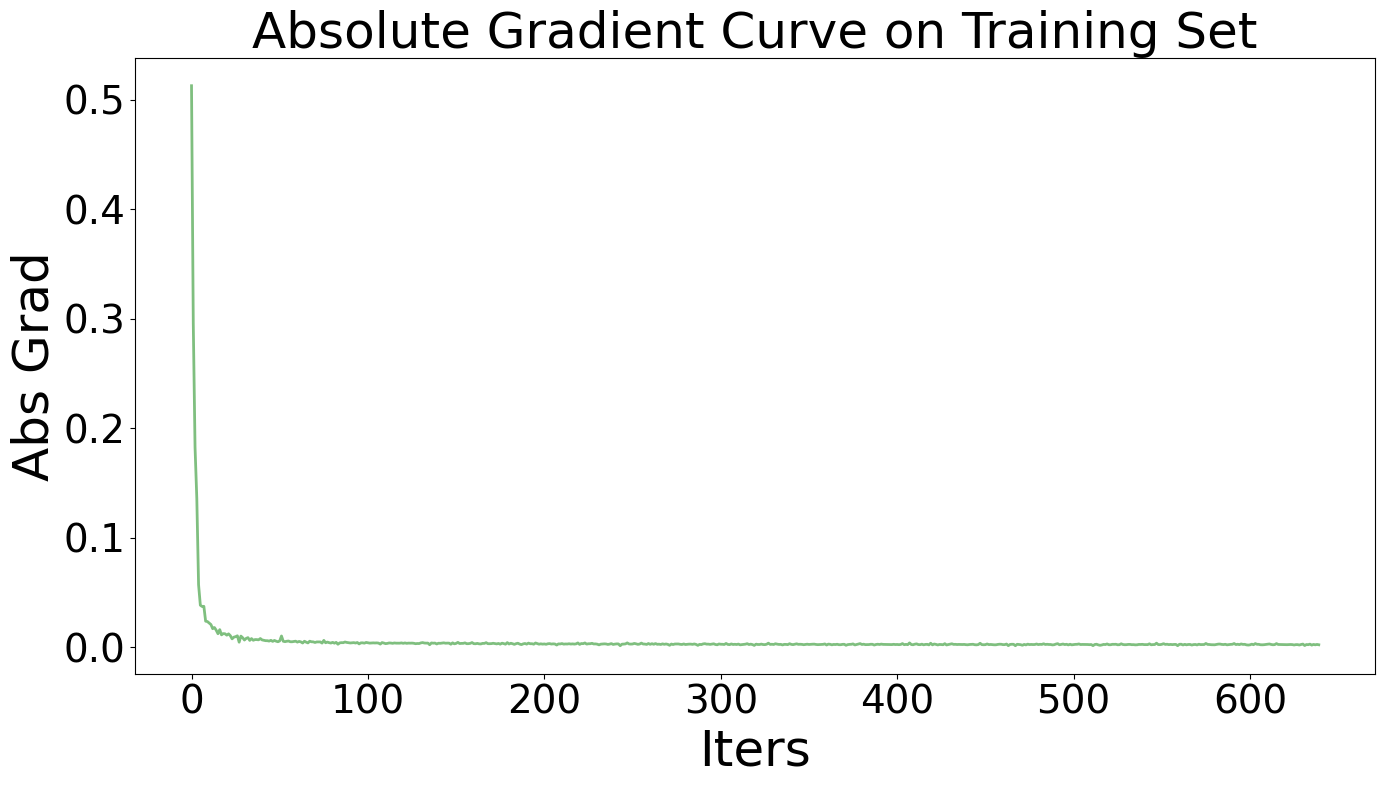

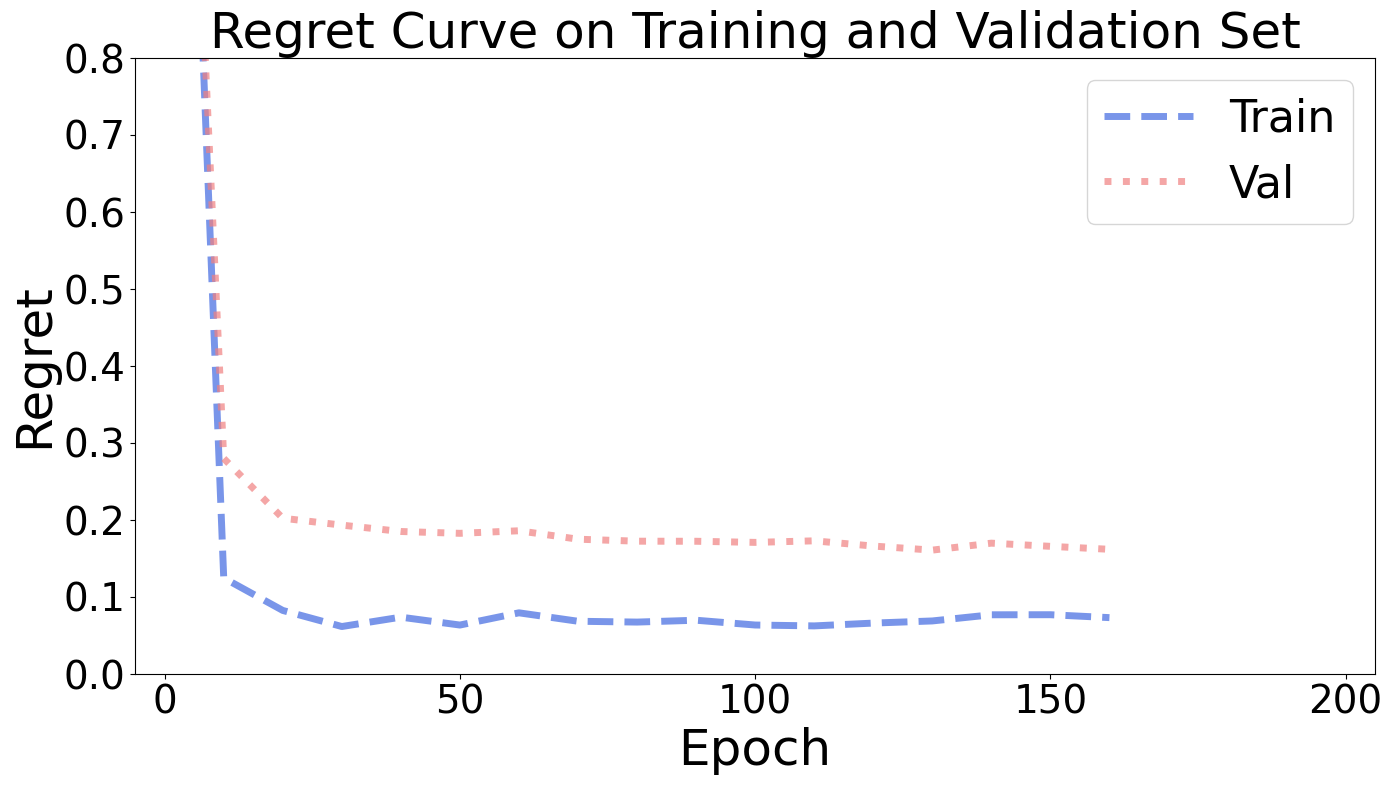

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 209.6206%, Val Regret: 188.7818%


Epoch    9, Loss:  -0.2916:   5%|██▋                                                  | 10/200 [00:15<03:32,  1.12s/it]

Epoch  10, Train Regret:  57.3375%, Val Regret:  74.2541%


Epoch   19, Loss:  -0.7687:  10%|█████▎                                               | 20/200 [00:28<03:22,  1.13s/it]

Epoch  20, Train Regret:  17.8000%, Val Regret:  35.2769%


Epoch   29, Loss:  -0.8190:  15%|███████▉                                             | 30/200 [00:41<03:11,  1.13s/it]

Epoch  30, Train Regret:  14.0399%, Val Regret:  25.8022%


Epoch   39, Loss:  -0.8171:  20%|██████████▌                                          | 40/200 [00:54<02:59,  1.12s/it]

Epoch  40, Train Regret:  12.9254%, Val Regret:  25.3556%


Epoch   49, Loss:  -0.8134:  25%|█████████████▎                                       | 50/200 [01:07<02:49,  1.13s/it]

Epoch  50, Train Regret:  14.2154%, Val Regret:  23.4044%


Epoch   59, Loss:  -0.8009:  30%|███████████████▉                                     | 60/200 [01:20<02:37,  1.13s/it]

Epoch  60, Train Regret:  13.4287%, Val Regret:  22.9084%


Epoch   69, Loss:  -0.8103:  35%|██████████████████▌                                  | 70/200 [01:33<02:27,  1.14s/it]

Epoch  70, Train Regret:  14.1105%, Val Regret:  22.8503%


Epoch   79, Loss:  -0.8165:  40%|█████████████████████▏                               | 80/200 [01:47<02:16,  1.14s/it]

Epoch  80, Train Regret:  14.7019%, Val Regret:  24.2917%


Epoch   89, Loss:  -0.8176:  45%|███████████████████████▊                             | 90/200 [02:00<02:04,  1.13s/it]

Epoch  90, Train Regret:  15.2106%, Val Regret:  23.7278%


Epoch   99, Loss:  -0.8079:  50%|██████████████████████████                          | 100/200 [02:13<01:52,  1.12s/it]

Epoch 100, Train Regret:  14.3635%, Val Regret:  21.9642%


Epoch  109, Loss:  -0.8130:  55%|████████████████████████████▌                       | 110/200 [02:26<01:41,  1.12s/it]

Epoch 110, Train Regret:  15.1750%, Val Regret:  23.6589%


Epoch  119, Loss:  -0.8168:  60%|███████████████████████████████▏                    | 120/200 [02:39<01:29,  1.12s/it]

Epoch 120, Train Regret:  13.6704%, Val Regret:  24.5141%


Epoch  129, Loss:  -0.8108:  65%|█████████████████████████████████▊                  | 130/200 [02:52<01:32,  1.32s/it]


Epoch 130, Train Regret:  13.0501%, Val Regret:  23.5051%

Early Stop!

Evaluation:
Test Regret: 23.1277%
Training Elapsed Time: 12.18 Sec


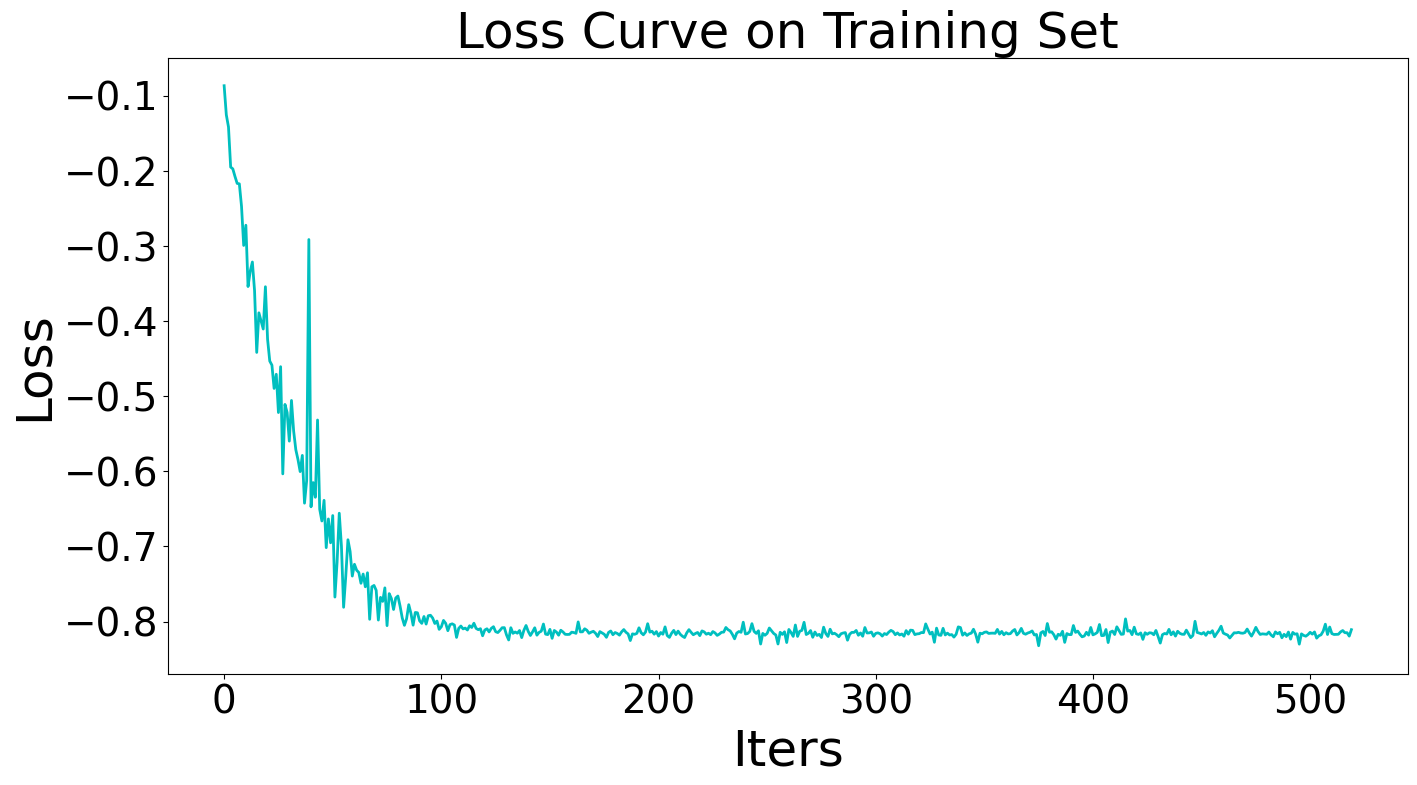

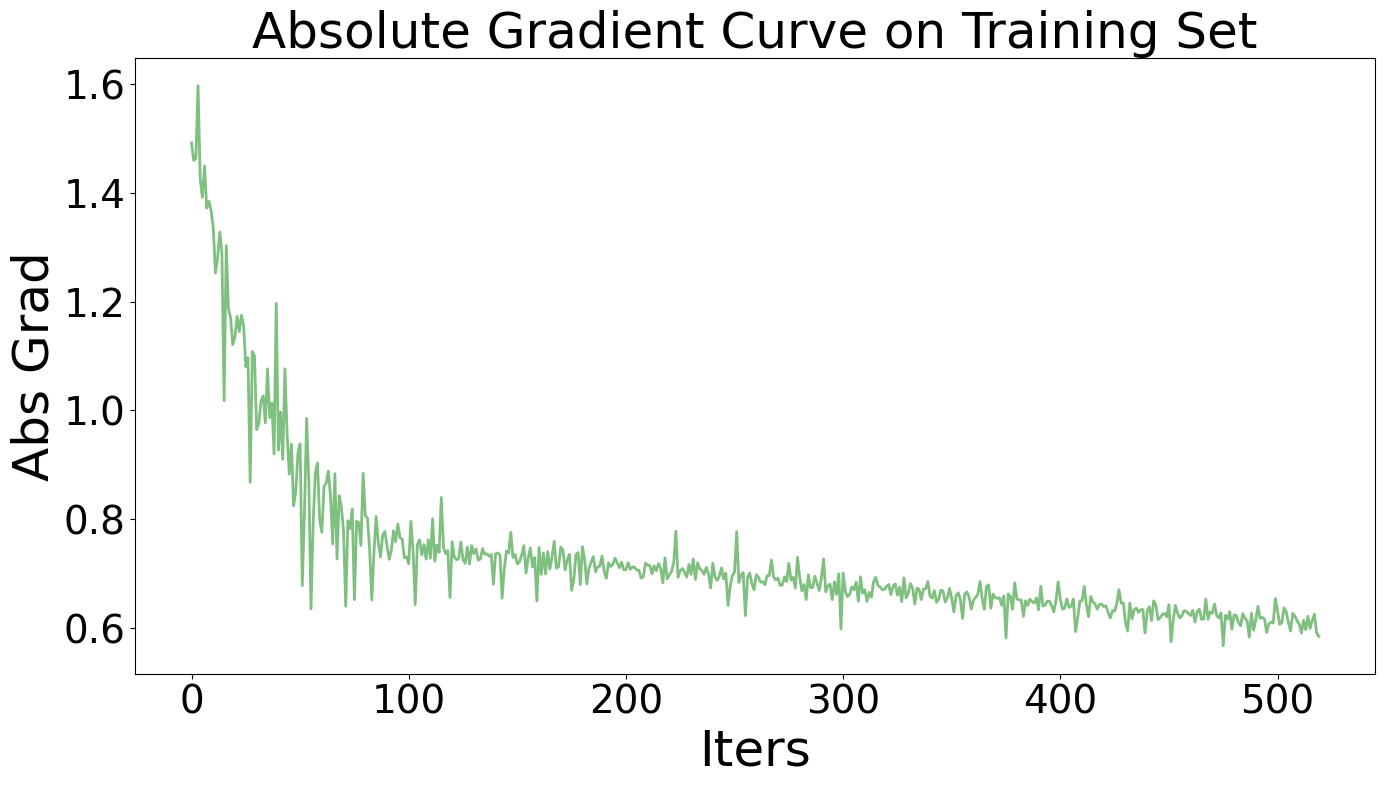

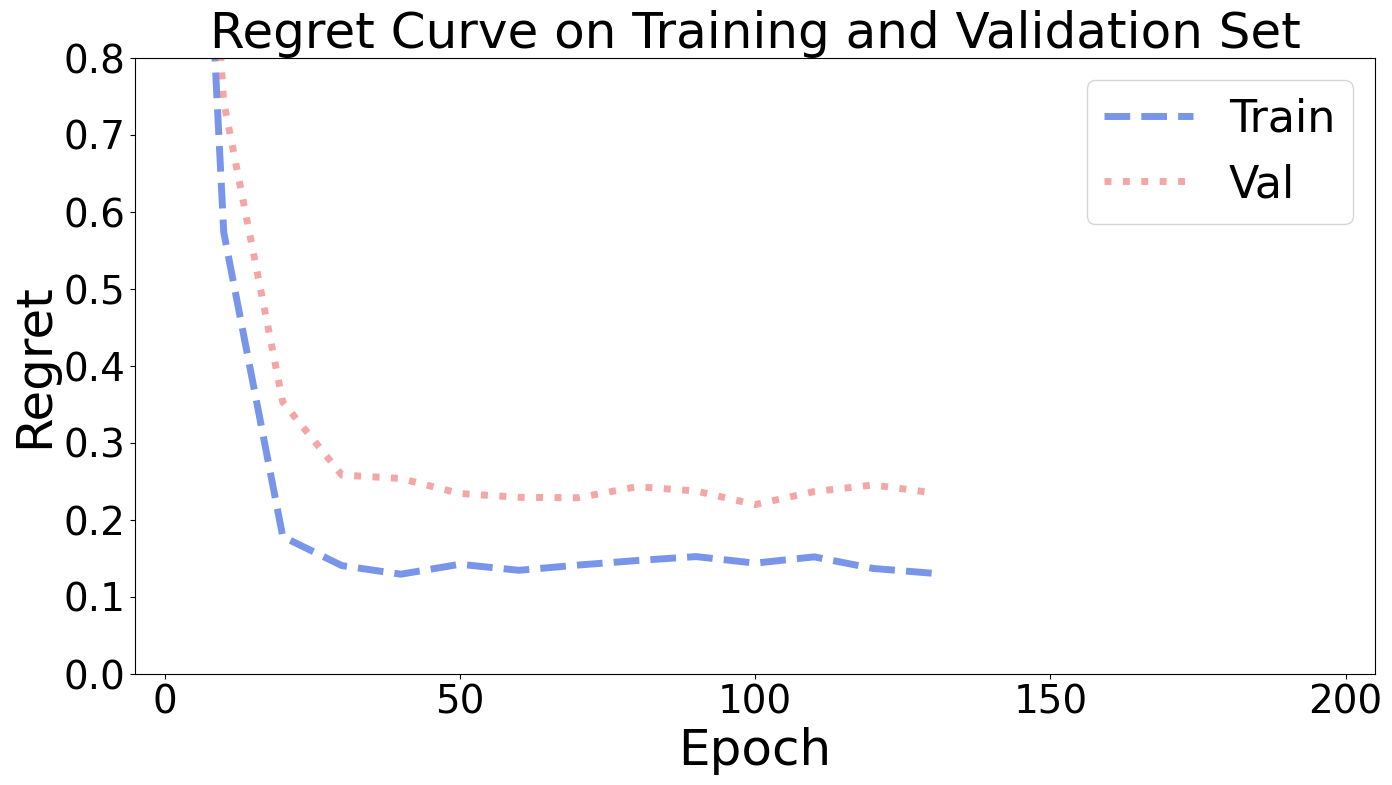

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 203.9385%, Val Regret: 191.5536%


Epoch    9, Loss:  -0.3229:   5%|██▋                                                  | 10/200 [00:19<04:57,  1.56s/it]

Epoch  10, Train Regret:  61.2268%, Val Regret:  78.5233%


Epoch   19, Loss:  -0.7725:  10%|█████▎                                               | 20/200 [00:36<04:39,  1.55s/it]

Epoch  20, Train Regret:  18.0591%, Val Regret:  33.5908%


Epoch   29, Loss:  -0.8130:  15%|███████▉                                             | 30/200 [00:54<04:25,  1.56s/it]

Epoch  30, Train Regret:  13.0220%, Val Regret:  24.3100%


Epoch   39, Loss:  -0.8176:  20%|██████████▌                                          | 40/200 [01:11<04:07,  1.55s/it]

Epoch  40, Train Regret:  13.5505%, Val Regret:  23.2700%


Epoch   49, Loss:  -0.8165:  25%|█████████████▎                                       | 50/200 [01:28<03:52,  1.55s/it]

Epoch  50, Train Regret:  14.3737%, Val Regret:  22.1048%


Epoch   59, Loss:  -0.7987:  30%|███████████████▉                                     | 60/200 [01:45<03:36,  1.54s/it]

Epoch  60, Train Regret:  14.0458%, Val Regret:  24.0173%


Epoch   69, Loss:  -0.8096:  35%|██████████████████▌                                  | 70/200 [02:03<03:19,  1.54s/it]

Epoch  70, Train Regret:  14.6360%, Val Regret:  22.9204%


Epoch   79, Loss:  -0.8154:  40%|█████████████████████▏                               | 80/200 [02:20<03:30,  1.76s/it]


Epoch  80, Train Regret:  14.1160%, Val Regret:  25.2488%

Early Stop!

Evaluation:
Test Regret: 22.6359%
Training Elapsed Time: 41.39 Sec


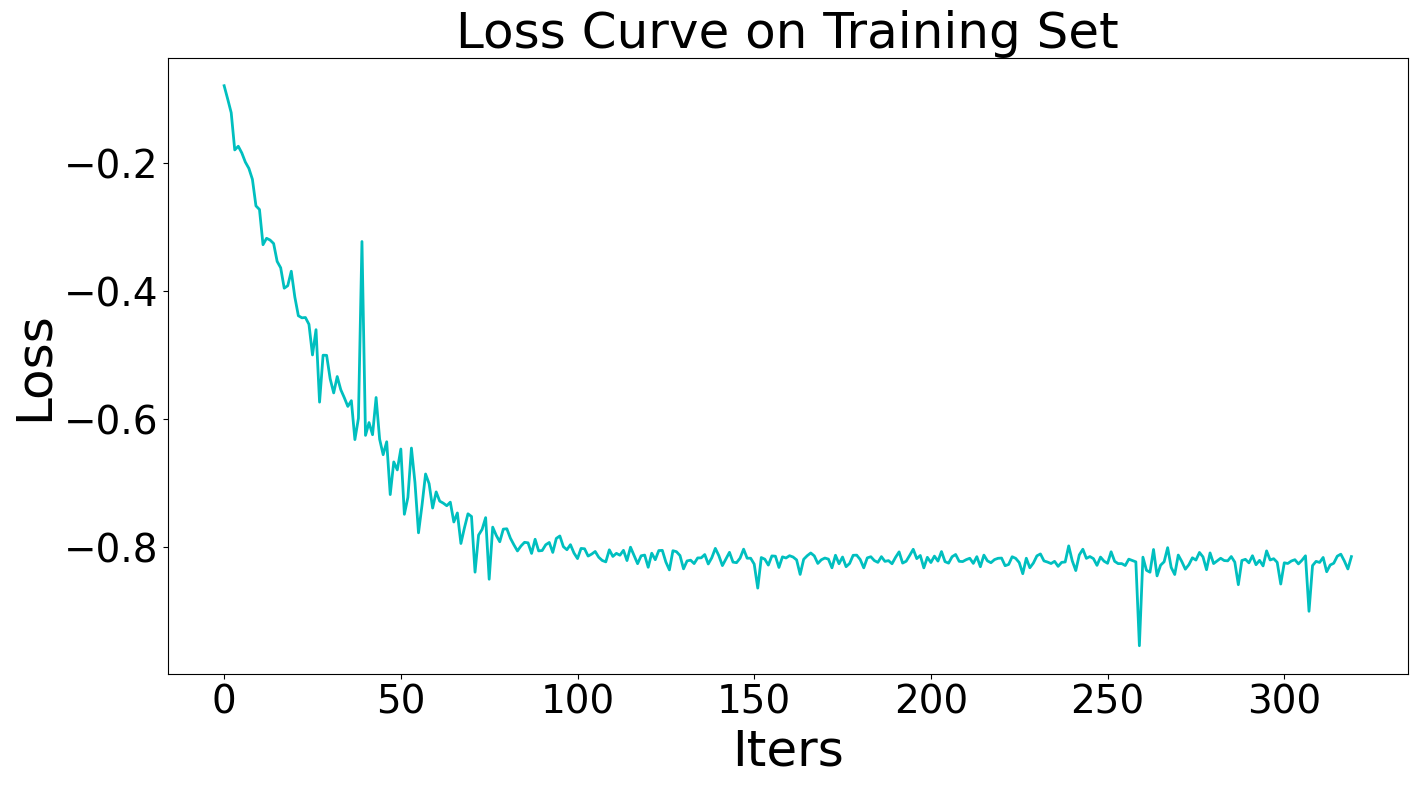

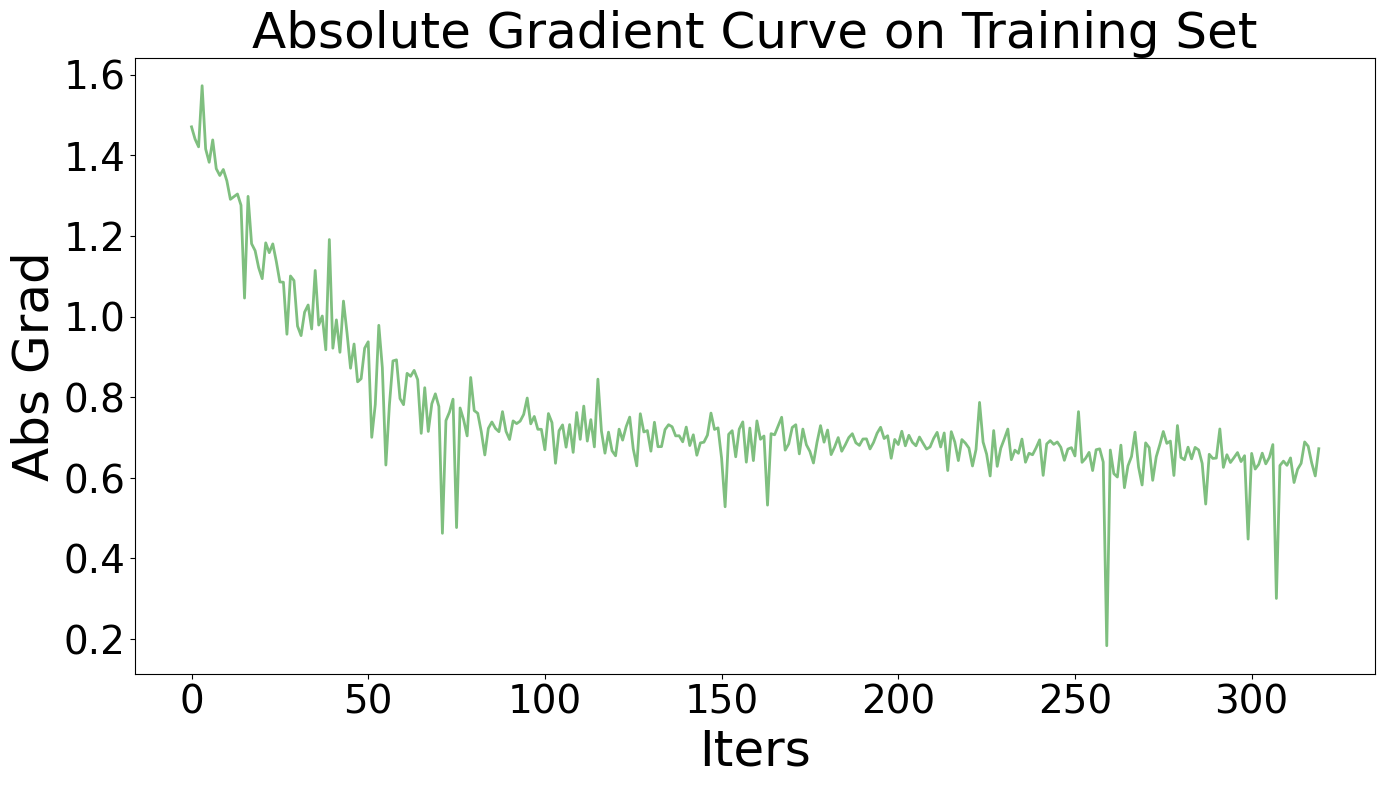

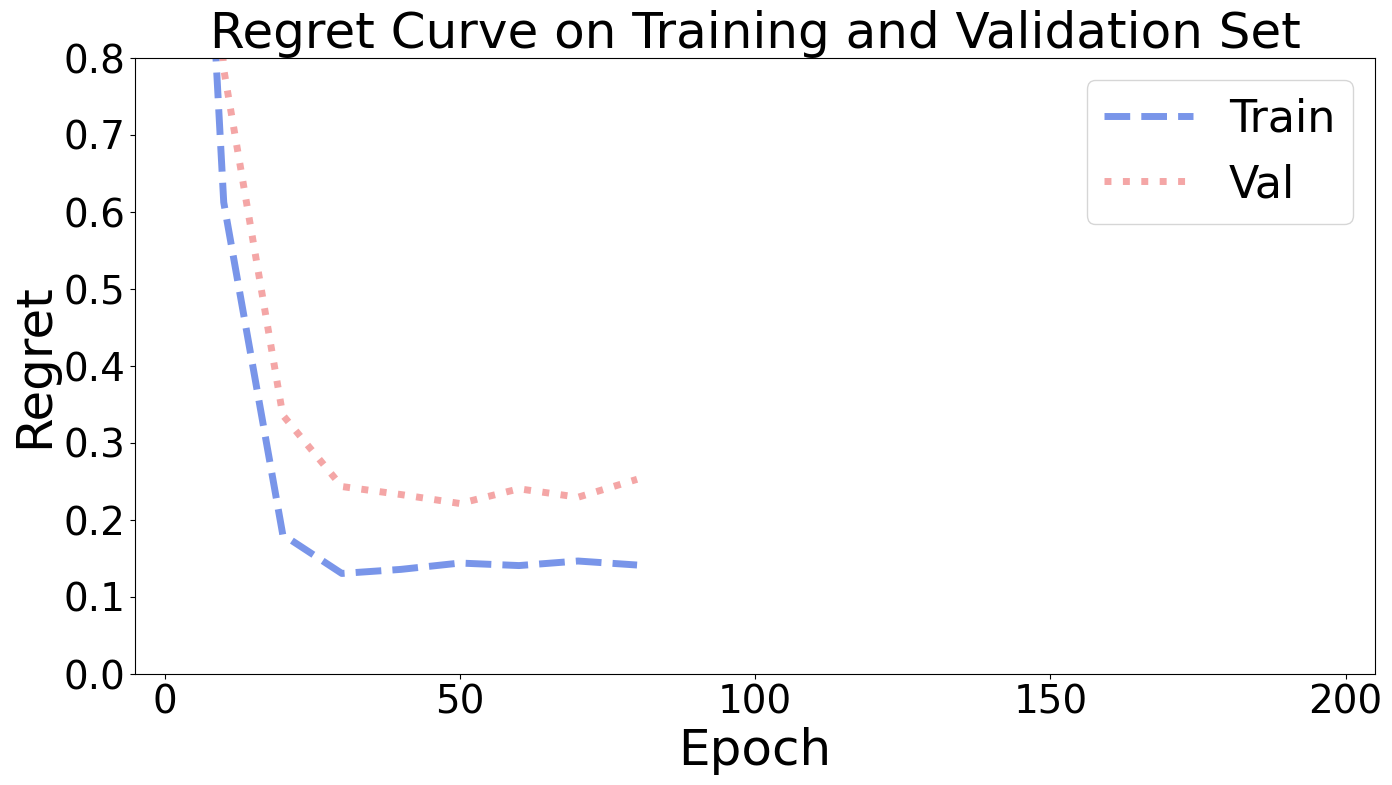

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 199.7919%, Val Regret: 194.5290%


Epoch    9, Loss:  -0.7214:   5%|██▋                                                  | 10/200 [00:14<03:21,  1.06s/it]

Epoch  10, Train Regret:  53.8699%, Val Regret:  69.5242%


Epoch   19, Loss:  -0.8599:  10%|█████▎                                               | 20/200 [00:26<03:10,  1.06s/it]

Epoch  20, Train Regret:  14.5661%, Val Regret:  26.0134%


Epoch   29, Loss:  -0.8926:  15%|███████▉                                             | 30/200 [00:38<02:59,  1.06s/it]

Epoch  30, Train Regret:  13.9622%, Val Regret:  22.8047%


Epoch   39, Loss:  -0.8795:  20%|██████████▌                                          | 40/200 [00:51<02:50,  1.06s/it]

Epoch  40, Train Regret:  13.6529%, Val Regret:  21.2519%


Epoch   49, Loss:  -0.8754:  25%|█████████████▎                                       | 50/200 [01:03<02:40,  1.07s/it]

Epoch  50, Train Regret:  13.0417%, Val Regret:  22.4600%


Epoch   59, Loss:  -0.8818:  30%|███████████████▉                                     | 60/200 [01:16<02:30,  1.07s/it]

Epoch  60, Train Regret:  13.6285%, Val Regret:  22.9089%


Epoch   69, Loss:  -0.8750:  35%|██████████████████▌                                  | 70/200 [01:29<02:45,  1.27s/it]


Epoch  70, Train Regret:  12.7753%, Val Regret:  23.0807%

Early Stop!

Evaluation:
Test Regret: 22.5171%
Training Elapsed Time: 2.38 Sec


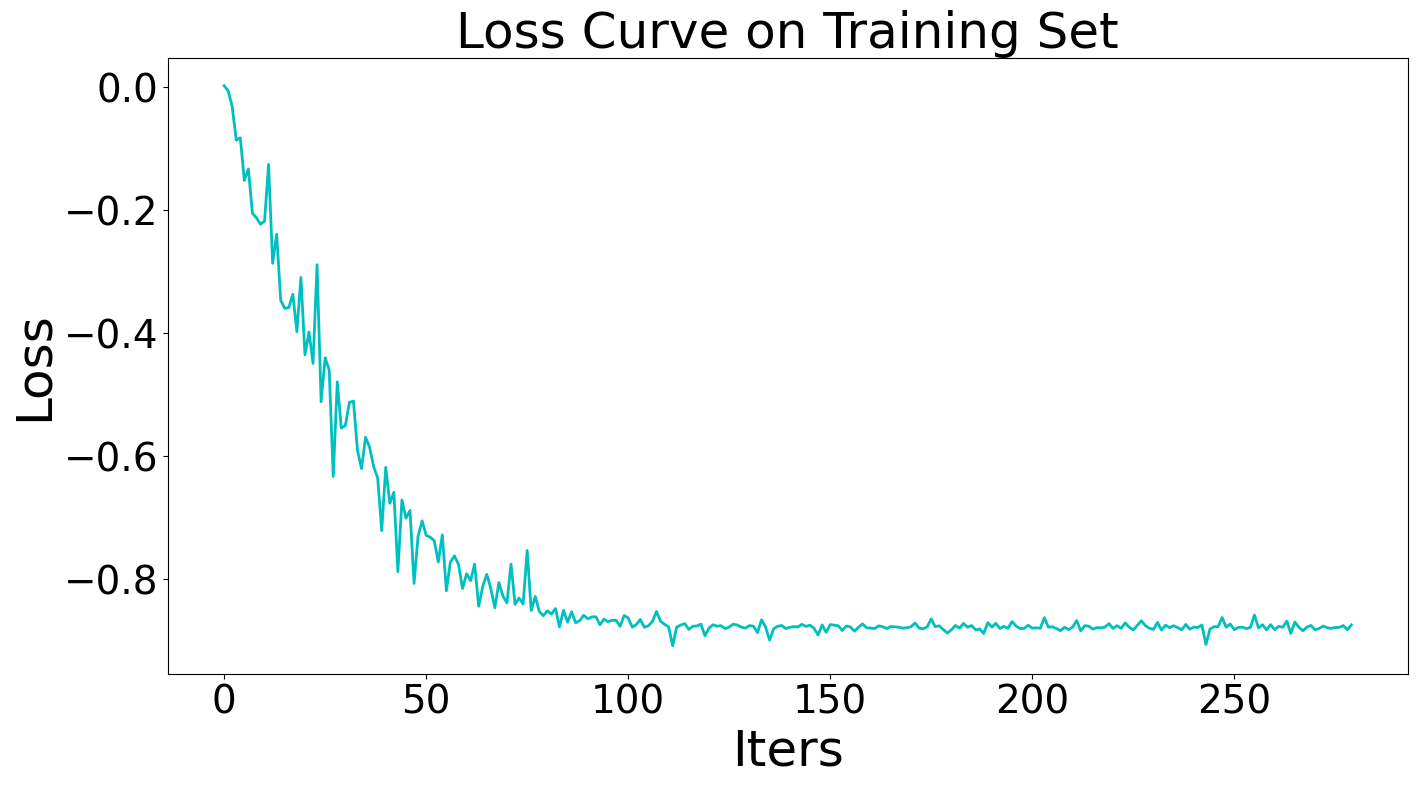

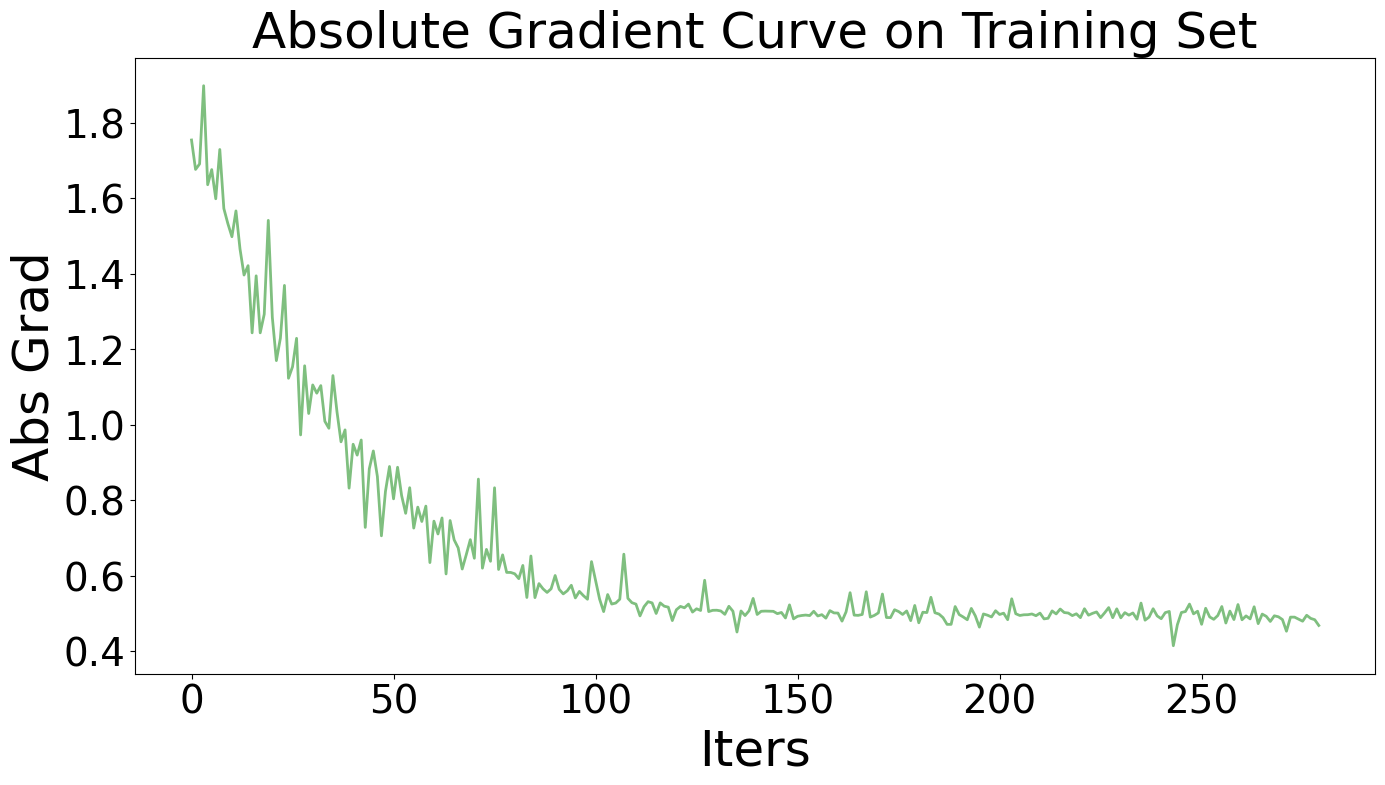

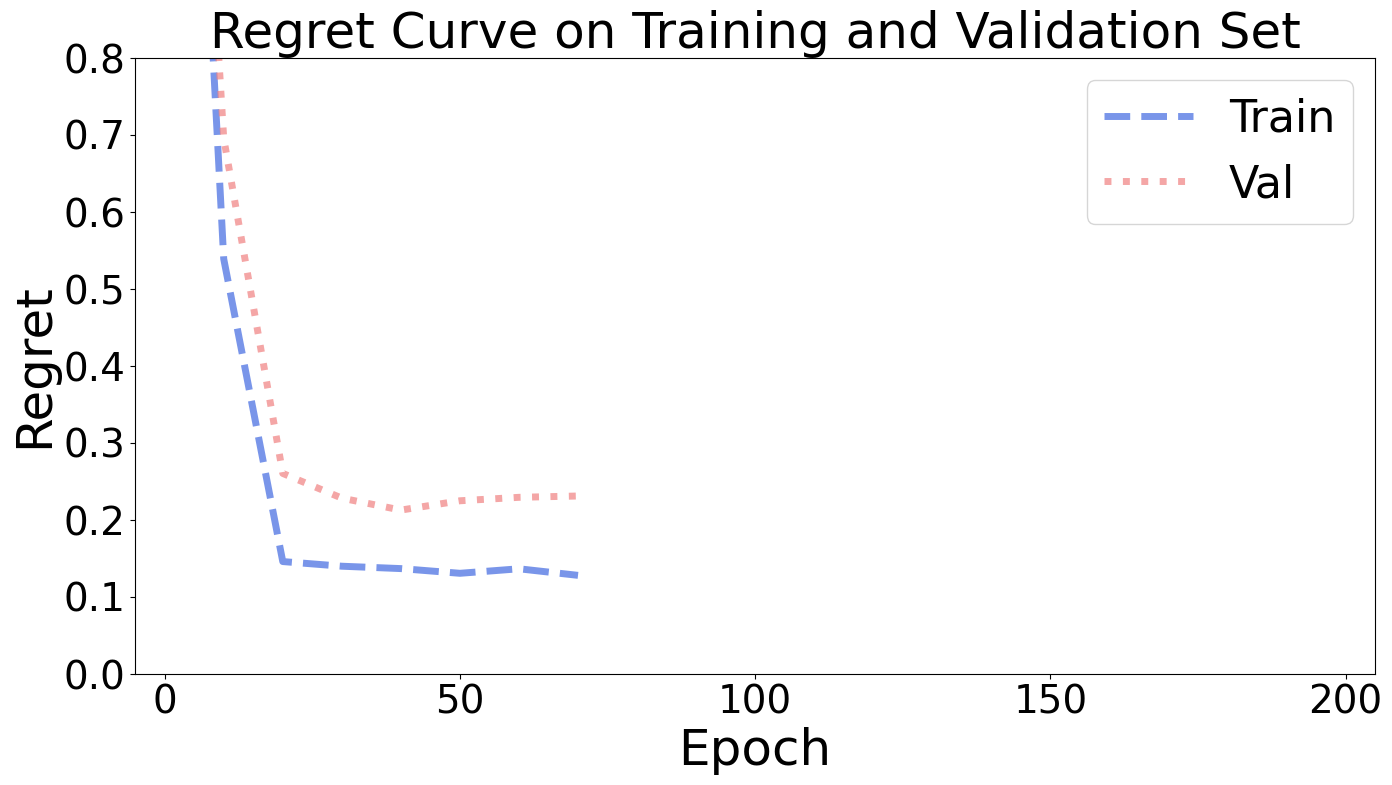

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [38]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:  -0.7116:   5%|██▋                                                  | 10/200 [00:19<04:51,  1.53s/it]

Epoch  10, Train Regret:  55.9446%, Val Regret:  70.0080%


Epoch   19, Loss:  -0.8590:  10%|█████▎                                               | 20/200 [00:35<04:21,  1.46s/it]

Epoch  20, Train Regret:  14.4644%, Val Regret:  26.2161%


Epoch   29, Loss:  -0.9086:  15%|███████▉                                             | 30/200 [00:52<04:13,  1.49s/it]

Epoch  30, Train Regret:  13.0335%, Val Regret:  21.7416%


Epoch   39, Loss:  -0.8808:  20%|██████████▌                                          | 40/200 [01:08<03:58,  1.49s/it]

Epoch  40, Train Regret:  12.5597%, Val Regret:  21.2626%


Epoch   49, Loss:  -0.9081:  25%|█████████████▎                                       | 50/200 [01:25<03:43,  1.49s/it]

Epoch  50, Train Regret:  12.2147%, Val Regret:  21.7565%


Epoch   59, Loss:  -0.8836:  30%|███████████████▉                                     | 60/200 [01:41<03:28,  1.49s/it]

Epoch  60, Train Regret:  13.4710%, Val Regret:  23.0041%


Epoch   69, Loss:  -0.8763:  35%|██████████████████▌                                  | 70/200 [01:58<03:40,  1.70s/it]


Epoch  70, Train Regret:  12.4874%, Val Regret:  21.8528%

Early Stop!

Evaluation:
Test Regret: 21.5336%
Training Elapsed Time: 31.93 Sec


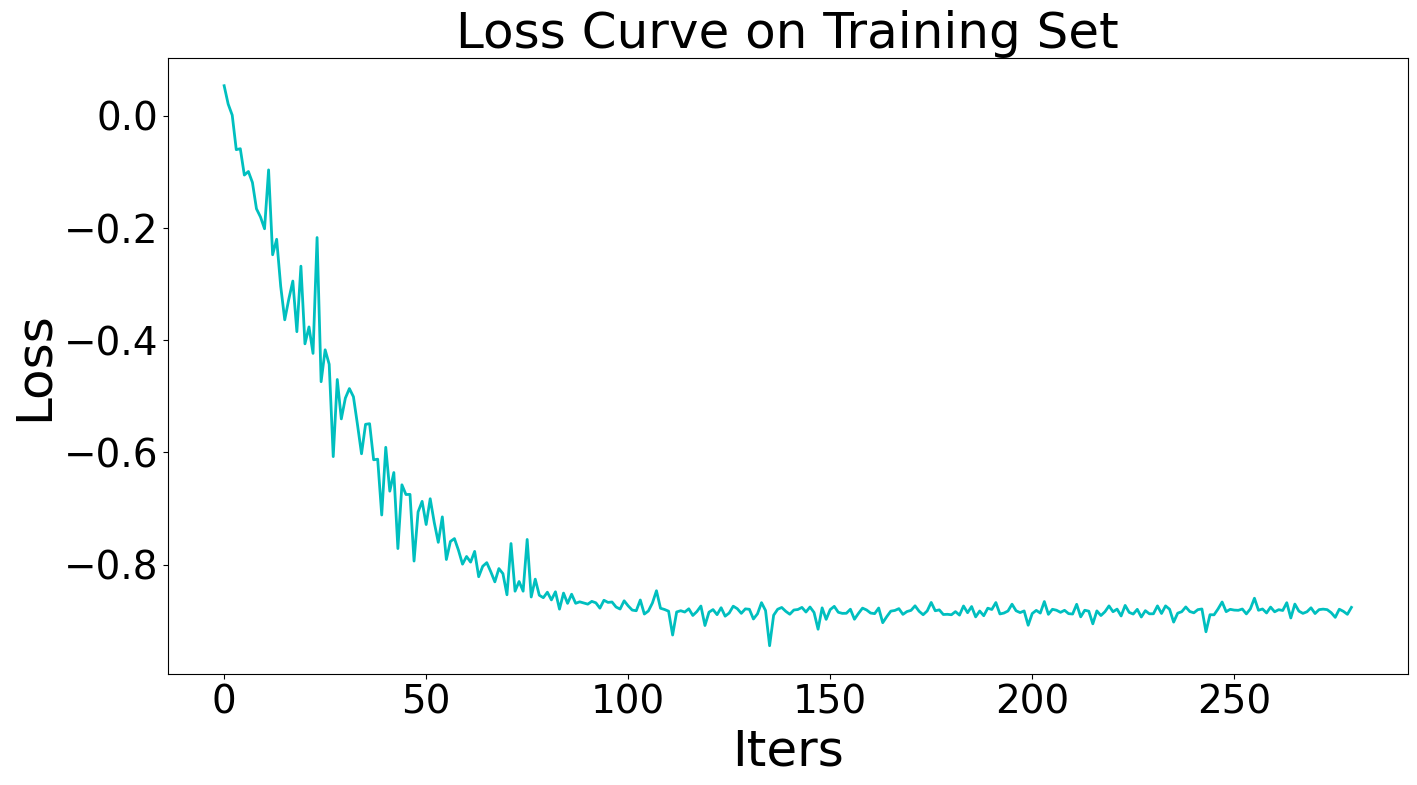

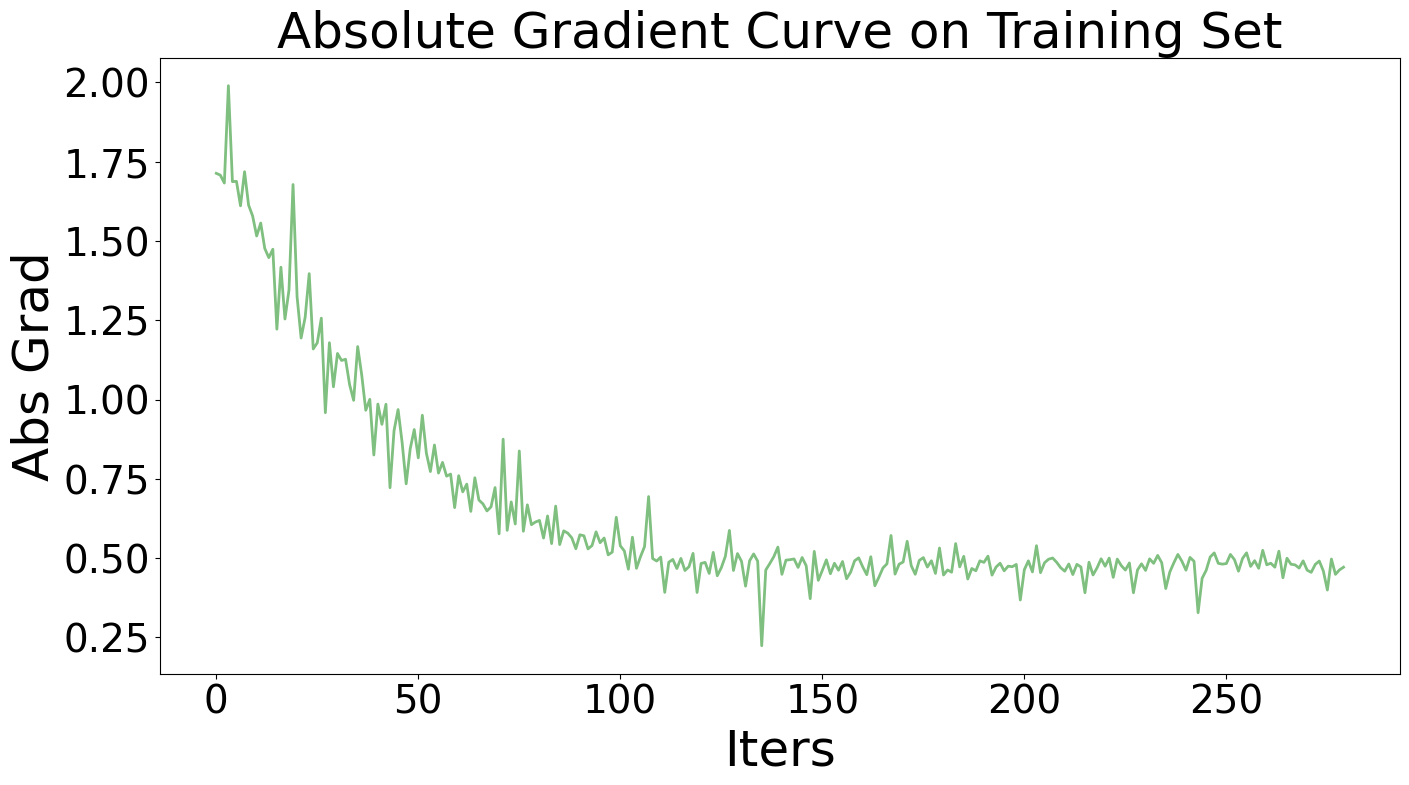

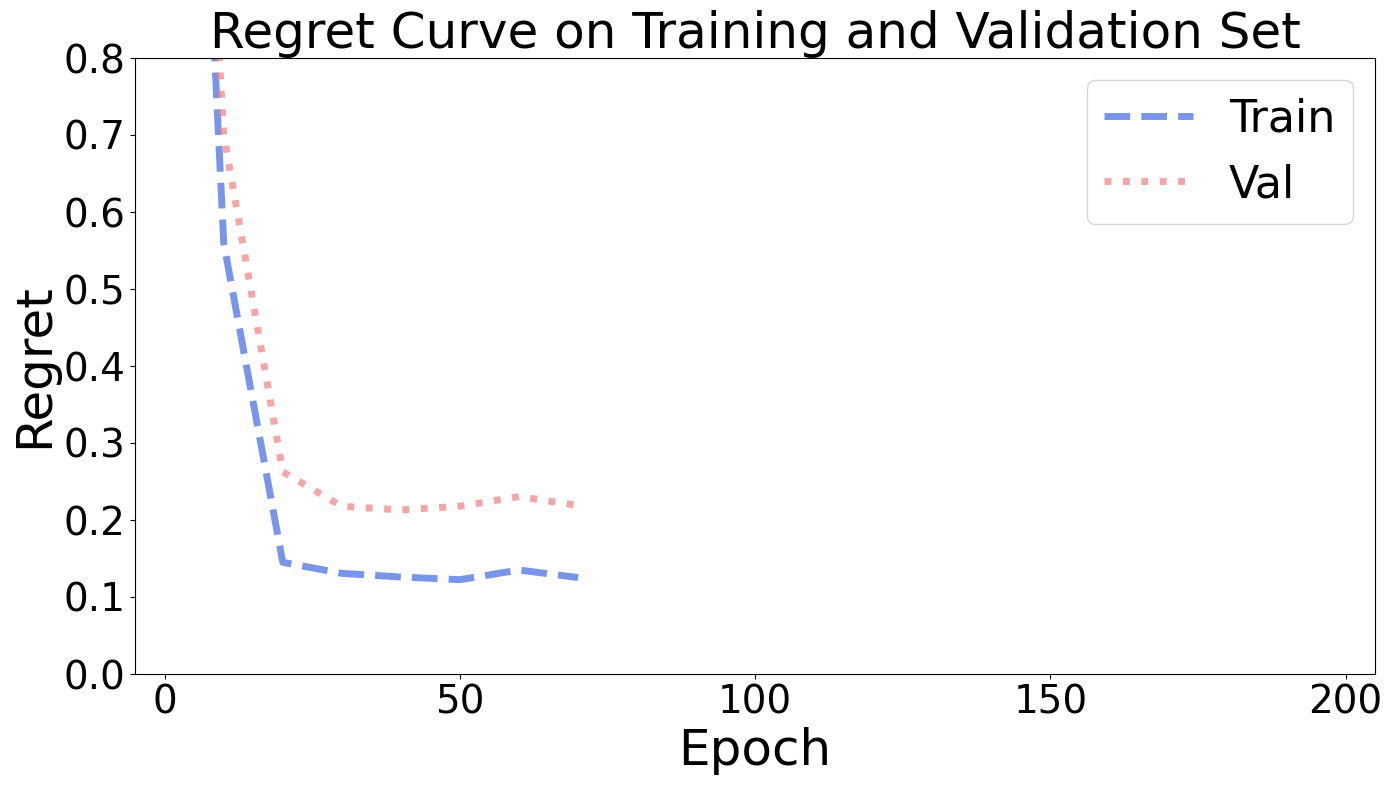

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:  19.0000:   5%|██▋                                                  | 10/200 [00:18<04:24,  1.39s/it]

Epoch  10, Train Regret:   8.8975%, Val Regret:  18.7136%


Epoch   19, Loss:  14.0000:  10%|█████▎                                               | 20/200 [00:33<04:10,  1.39s/it]

Epoch  20, Train Regret:   5.7635%, Val Regret:  17.1914%


Epoch   29, Loss:   8.0000:  15%|███████▉                                             | 30/200 [00:49<03:56,  1.39s/it]

Epoch  30, Train Regret:   5.1898%, Val Regret:  17.5069%


Epoch   39, Loss:  17.0000:  20%|██████████▌                                          | 40/200 [01:04<03:37,  1.36s/it]

Epoch  40, Train Regret:   4.6886%, Val Regret:  18.0484%


Epoch   49, Loss:  12.0000:  25%|█████████████▎                                       | 50/200 [01:20<03:25,  1.37s/it]

Epoch  50, Train Regret:   3.7860%, Val Regret:  16.0817%


Epoch   59, Loss:   9.0000:  30%|███████████████▉                                     | 60/200 [01:35<03:14,  1.39s/it]

Epoch  60, Train Regret:   2.7645%, Val Regret:  16.1116%


Epoch   69, Loss:  11.0000:  35%|██████████████████▌                                  | 70/200 [01:51<03:02,  1.40s/it]

Epoch  70, Train Regret:   2.9893%, Val Regret:  15.7322%


Epoch   79, Loss:   7.5000:  40%|█████████████████████▏                               | 80/200 [02:07<02:47,  1.40s/it]

Epoch  80, Train Regret:   3.1794%, Val Regret:  16.8864%


Epoch   89, Loss:   8.0000:  45%|███████████████████████▊                             | 90/200 [02:22<02:32,  1.39s/it]

Epoch  90, Train Regret:   2.1112%, Val Regret:  16.1381%


Epoch   99, Loss:  10.5000:  50%|██████████████████████████                          | 100/200 [02:38<02:38,  1.58s/it]


Epoch 100, Train Regret:   2.5469%, Val Regret:  16.2231%

Early Stop!

Evaluation:
Test Regret: 16.6400%
Training Elapsed Time: 35.50 Sec


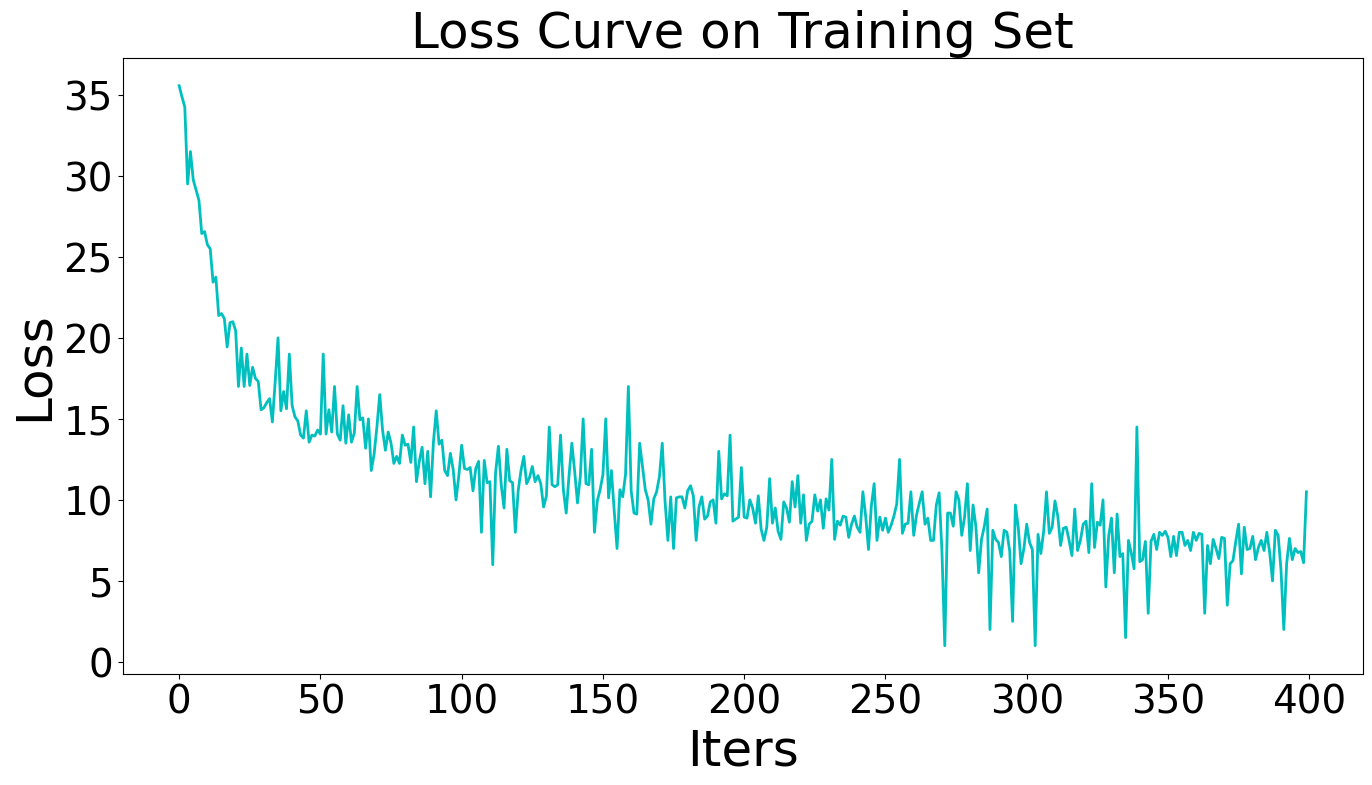

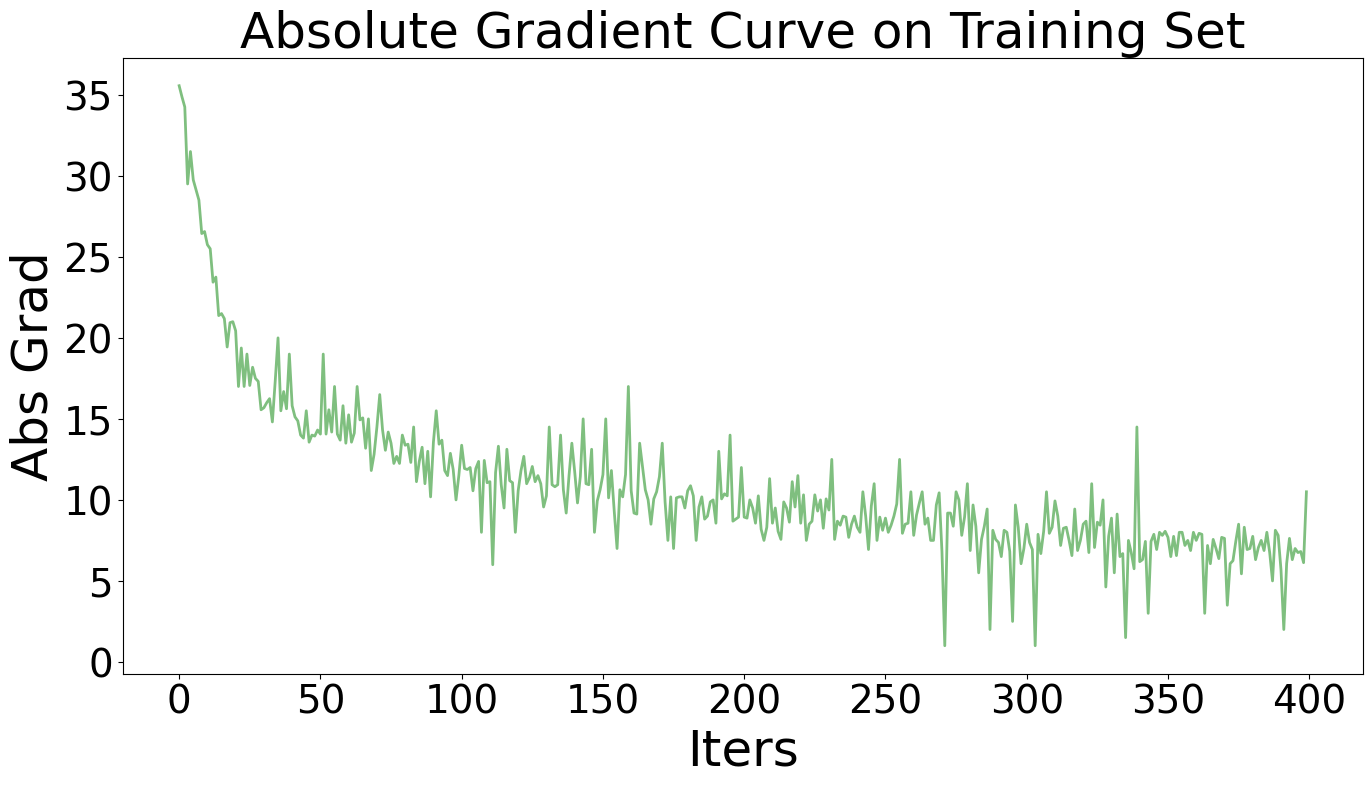

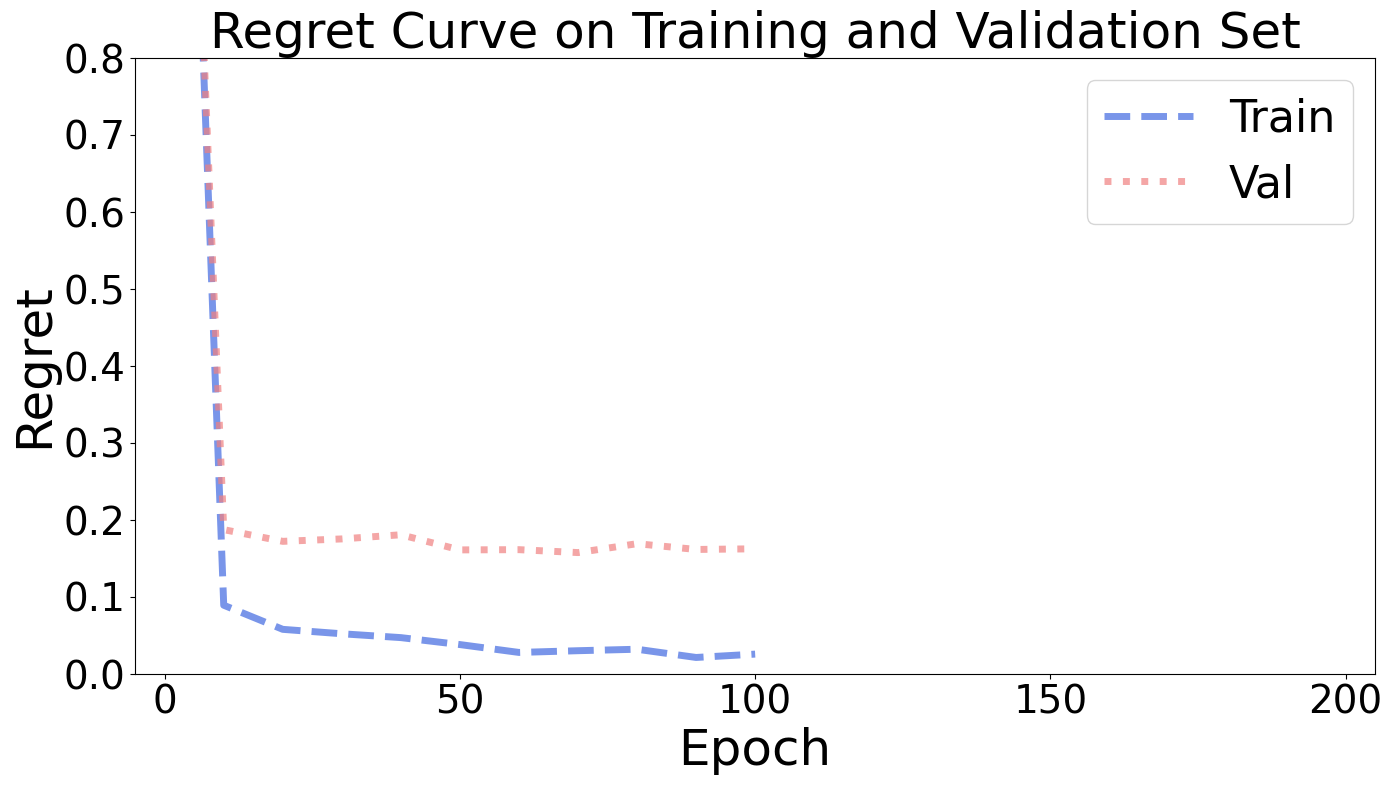

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [46]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 208.2675%, Val Regret: 201.2711%


Epoch    9, Loss: -82.7803:   5%|██▋                                                  | 10/200 [00:14<03:24,  1.08s/it]

Epoch  10, Train Regret:  22.2716%, Val Regret:  35.9861%


Epoch   19, Loss: -194.0414:  10%|█████▏                                              | 20/200 [00:27<03:15,  1.09s/it]

Epoch  20, Train Regret:  17.7970%, Val Regret:  30.5015%


Epoch   29, Loss: -332.3475:  15%|███████▊                                            | 30/200 [00:39<03:02,  1.07s/it]

Epoch  30, Train Regret:  16.8811%, Val Regret:  29.5048%


Epoch   39, Loss: -350.5912:  20%|██████████▍                                         | 40/200 [00:52<02:52,  1.08s/it]

Epoch  40, Train Regret:  15.7863%, Val Regret:  28.7805%


Epoch   49, Loss: -391.3070:  25%|█████████████                                       | 50/200 [01:04<02:39,  1.06s/it]

Epoch  50, Train Regret:  16.1232%, Val Regret:  27.8235%


Epoch   59, Loss: -598.9451:  30%|███████████████▌                                    | 60/200 [01:17<02:33,  1.10s/it]

Epoch  60, Train Regret:  15.7184%, Val Regret:  28.0726%


Epoch   69, Loss: -504.0792:  35%|██████████████████▏                                 | 70/200 [01:29<02:17,  1.06s/it]

Epoch  70, Train Regret:  15.6764%, Val Regret:  27.7914%


Epoch   79, Loss: -713.9517:  40%|████████████████████▊                               | 80/200 [01:42<02:10,  1.09s/it]

Epoch  80, Train Regret:  15.4101%, Val Regret:  26.9381%


Epoch   89, Loss: -707.2506:  45%|███████████████████████▍                            | 90/200 [01:55<02:02,  1.11s/it]

Epoch  90, Train Regret:  15.3174%, Val Regret:  27.1579%


Epoch   99, Loss: -731.8303:  50%|█████████████████████████▌                         | 100/200 [02:08<01:46,  1.07s/it]

Epoch 100, Train Regret:  16.1925%, Val Regret:  26.2942%


Epoch  109, Loss: -782.1286:  55%|████████████████████████████                       | 110/200 [02:20<01:35,  1.06s/it]

Epoch 110, Train Regret:  15.3962%, Val Regret:  26.9953%


Epoch  119, Loss: -1437.7554:  60%|██████████████████████████████                    | 120/200 [02:33<01:28,  1.10s/it]

Epoch 120, Train Regret:  15.2339%, Val Regret:  26.8645%


Epoch  129, Loss: -870.5099:  65%|█████████████████████████████████▏                 | 130/200 [02:45<01:29,  1.28s/it]


Epoch 130, Train Regret:  14.8950%, Val Regret:  27.3385%

Early Stop!

Evaluation:
Test Regret: 28.6163%
Training Elapsed Time: 6.46 Sec


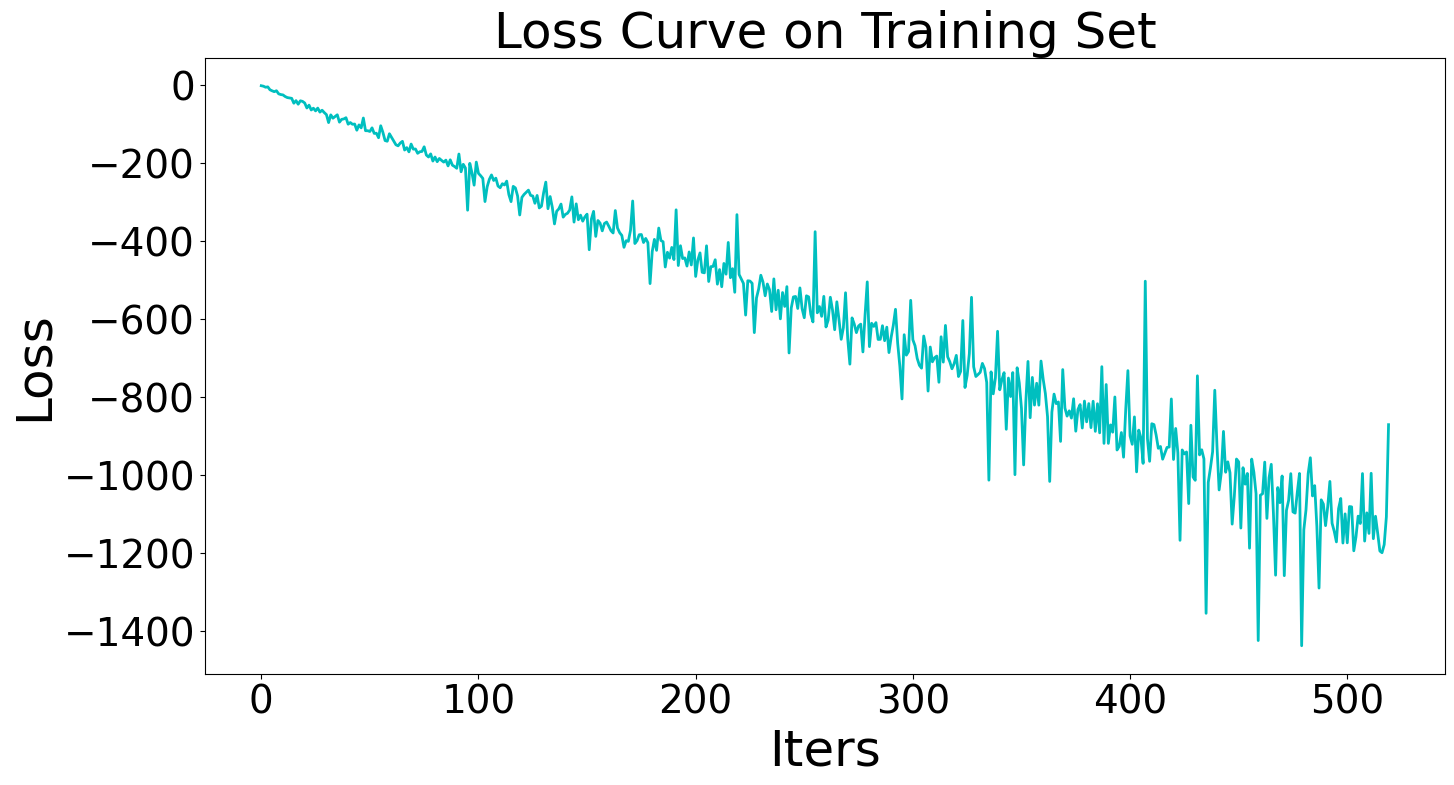

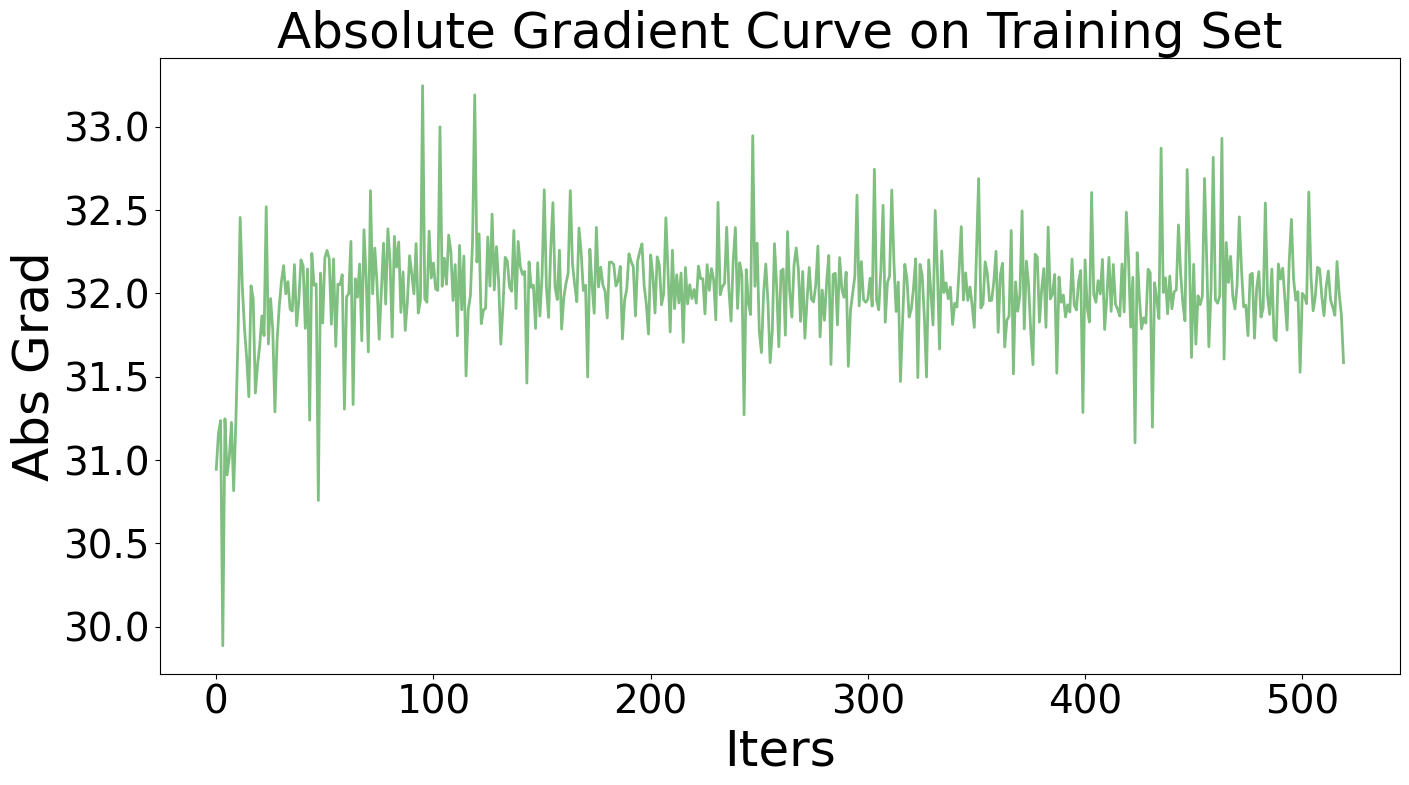

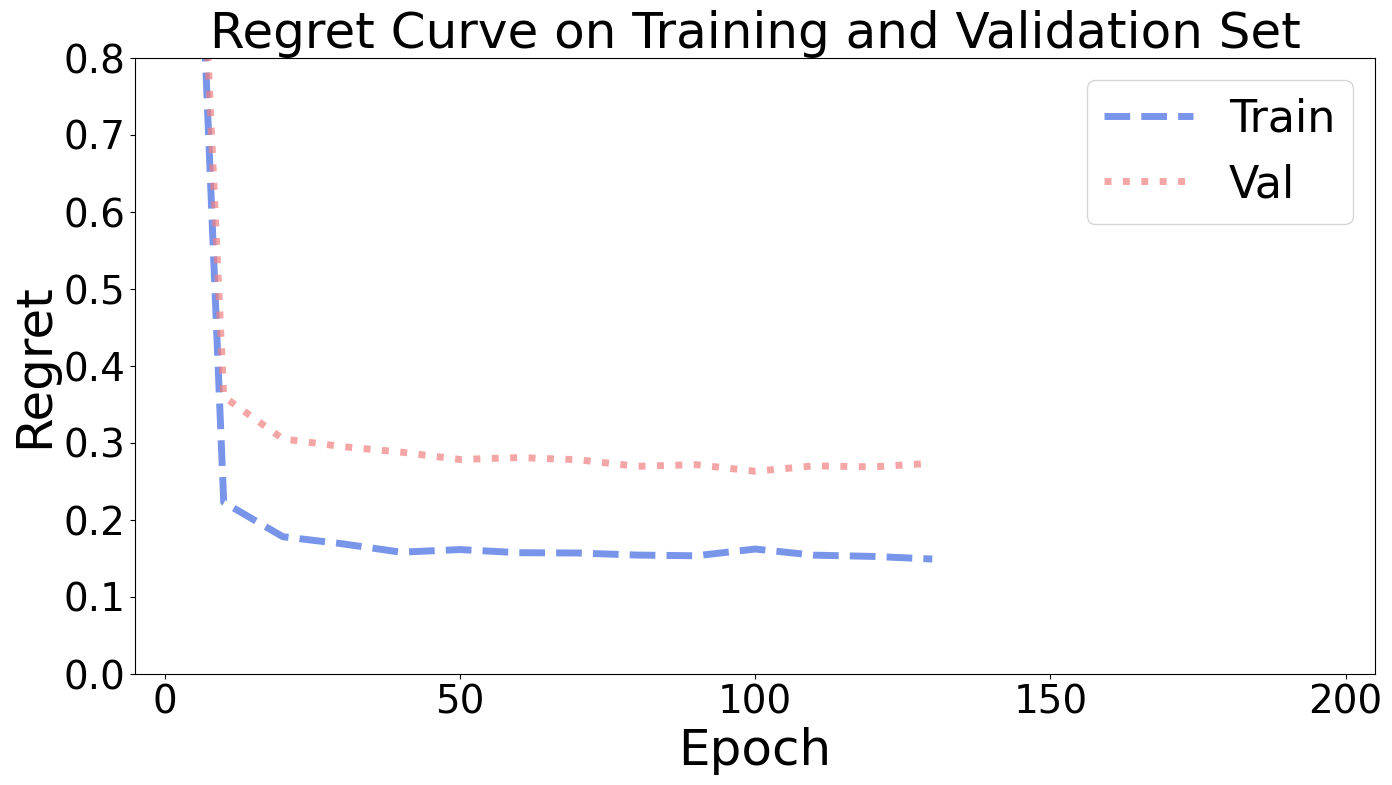

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)